<a href="https://colab.research.google.com/github/christyesmee/Thesis/blob/main/ResU_Net_O.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

drive_path = "/content/drive"
drive.mount(drive_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
import os
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import models
from tqdm.notebook import tqdm, trange
from sklearn.model_selection import KFold
from torchvision.models.resnet import ResNet18_Weights

In [ ]:
# # File path setup
# img_dir = "Thesis Esmee/processed/1718_sat"
# folder_path = f"{drive_path}/MyDrive/{img_dir}"

# # Image path & scale
# file_name = "galicia_split_image"
# file_path = f"{folder_path}/{file_name}"
# target_name = "1819_sat/ndvi1819"
# target_path = f"{folder_path}/{target_name}"
# scale = 10  # pixels per meter
# AS_TYPE = torch.float32

# Setup

Input, Output, and Target for Training and Testing
Training Phase

    Input:
        The input to the model will consist of the following bands from Sentinel-2A data for the period "2017-6-22" - "2018-6-22":
            Red band
            Green band
            Blue band
            Near-Infrared (NIR) band
            NDVI layer (calculated from the NIR and Red bands)

    These bands will be stacked to form a multi-channel input. Therefore, the input will have 5 channels.

    Output:
        The output of the ResUNet model will be the NDVI, predicting the NDVI for the period of "2018-6-22" - "2019-6-22".

    Target:
        The target during training is the true NDVI for the period of "2018-6-22" - "2019-6-22"​.

Detailed Process
Preparing Data

    Calculate Ground Truth NDVI Difference:
        Compute the ground truth NDVI difference map ΔNDVItrueΔNDVItrue​ for each pixel:
        ΔNDVItrue=NDVI2018−2019−NDVI2017−2018
        ΔNDVItrue​=NDVI2018−2019​−NDVI2017−2018​
        This map represents the actual change in NDVI between the two periods and will be used as the target for training the model.

Training the Model

    Input Preparation:
        Prepare the input by stacking the Red, Green, Blue, NIR, and NDVI bands from the 2017-2018 period. This results in a 5-channel input for each pixel.

    Output Definition:
        The model's output is set to predict the NDVI difference map ΔNDVIpredΔNDVIpred​.

    Training Process:
        The model is trained to minimize the difference between the predicted NDVI difference map ΔNDVIpredΔNDVIpred​ and the ground truth NDVI difference map ΔNDVItrueΔNDVItrue​.
        The loss function (e.g., Mean Squared Error) will compare ΔNDVIpredΔNDVIpred​ with ΔNDVItrueΔNDVItrue​ and update the model weights to minimize this error.

Testing and Inference

    Input for Testing:
        For testing, use the Sentinel-2A data (Red, Green, Blue, NIR, and NDVI bands) for the period 2018-2019 as the input to the model.

    Output for Testing:
        The model will output the predicted NDVI difference map ΔNDVIpredΔNDVIpred​ for the period 2018-2019 relative to 2017-2018.

    Evaluating the Model:
        Compare the predicted NDVI difference map ΔNDVIpredΔNDVIpred​ with the actual NDVI difference map ΔNDVItrueΔNDVItrue​ computed for the period 2018-2019.

Summary

    Training Phase:
        Input: Sentinel-2A bands (Red, Green, Blue, NIR, NDVI) for 2017-2018 (5-channel input).
        Output: Predicted NDVI difference map ΔNDVIpredΔNDVIpred​.
        Target: Ground truth NDVI difference map ΔNDVItrue=NDVI2018−2019−NDVI2017−2018ΔNDVItrue​=NDVI2018−2019​−NDVI2017−2018​.

    Testing Phase:
        Input: Sentinel-2A bands (Red, Green, Blue, NIR, NDVI) for 2018-2019 (5-channel input).
        Output: Predicted NDVI difference map ΔNDVIpredΔNDVIpred​ for 2018-2019 relative to 2017-2018.
        Evaluation: Compare ΔNDVIpredΔNDVIpred​ with ΔNDVItrueΔNDVItrue​.

# Dataloader

In [ ]:

import os
import torch
from torch.utils.data import Dataset

class NDVI(Dataset):
    def __init__(self, images_dir, targets_dir):
        self.images_dir = images_dir
        self.targets_dir = targets_dir
        self.image_files = sorted([f for f in os.listdir(images_dir) if f.endswith('.pt')])
        self.target_files = sorted([f for f in os.listdir(targets_dir) if f.endswith('.pt')])

        print(f"Dataset size: {len(self.image_files)} samples")
        print(f"Target size: {len(self.target_files)} samples")

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = os.path.join(self.images_dir, self.image_files[idx])
        target_path = os.path.join(self.targets_dir, self.target_files[idx])

        try:
            image = torch.load(image_path)
        except Exception as e:
            print(f"Failed to load image file '{image_path}': {e}")
            raise RuntimeError(f"Failed to load image file '{image_path}': {e}")

        try:
            target = torch.load(target_path)
        except Exception as e:
            print(f"Failed to load target file '{target_path}': {e}")
            raise RuntimeError(f"Failed to load target file '{target_path}': {e}")

        target = target.unsqueeze(0)  # Add a channel dimension at position 0 if not already there

        return image, target

# Example usage
images_dir = '/content/drive/MyDrive/17_ont_pt_256_rad50'
targets_dir = "/content/drive/MyDrive/18_sat_ndvi_labels_256"

dataset = NDVI(images_dir, targets_dir)

Dataset size: 3969 samples
Target size: 3969 samples


# Cross-Validation

In [ ]:
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Train/Validation/Test split
test_split = 0.2
test_size = int(len(dataset) * test_split)
train_val_size = len(dataset) - test_size
train_val_dataset, test_dataset = random_split(dataset, [train_val_size, test_size])

In [ ]:
def create_dataloaders(train_val_dataset, test_dataset, train_indices, val_indices, batch_size=16):
    train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
    val_sampler = torch.utils.data.SubsetRandomSampler(val_indices)

    train_loader = DataLoader(train_val_dataset, batch_size=batch_size, sampler=train_sampler)
    val_loader = DataLoader(train_val_dataset, batch_size=batch_size, sampler=val_sampler)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


    return train_loader, val_loader, test_loader

# Model

In [ ]:
class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, skip_channels):
        super(UpBlock, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        # New number of input channels after concatenation: out_channels from `up` + skip_channels
        self.conv_block = self._conv_block(out_channels + skip_channels, out_channels)

    def _conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x, skip):
        x = self.up(x)
        x = torch.cat((x, skip), dim=1)  # Concatenate along channel dimension
        return self.conv_block(x)

class ResUNet(nn.Module):
    def __init__(self, in_channels=8, out_channels=1):
        super(ResUNet, self).__init__()

        # Load pretrained ResNet-18 and modify the first layer to accept in_channels
        resnet = models.resnet18(weights=ResNet18_Weights.DEFAULT)
        self.initial = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.initial_bn = resnet.bn1
        self.initial_relu = resnet.relu
        self.initial_pool = resnet.maxpool

        # Use ResNet layers as encoder blocks
        self.encoder1 = resnet.layer1
        self.encoder2 = resnet.layer2
        self.encoder3 = resnet.layer3
        self.encoder4 = resnet.layer4

        # Decoder blocks with updated skip channels
        self.up3 = UpBlock(512, 256, 256)  # Using 512 channels from x4, upscaling to 256, concatenating with 256 from x3
        self.up2 = UpBlock(256, 128, 128)  # Using 256 channels from up3 output, upscaling to 128, concatenating with 128 from x2
        self.up1 = UpBlock(128, 64, 64)    # Using 128 channels from up2 output, upscaling to 64, concatenating with 64 from x1
        self.up0 = UpBlock(64, 64, 64)     # Using 64 channels from up1 output, upscaling to 64, concatenating with 64 from x0

        # Final upsampling layer to restore original spatial dimensions
        self.final_upsample = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)

        # Final convolution layer
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)


    def forward(self, x):
        # Encoder
        x0 = self.initial_relu(self.initial_bn(self.initial(x)))
        x1 = self.encoder1(self.initial_pool(x0))
        x2 = self.encoder2(x1)
        x3 = self.encoder3(x2)
        x4 = self.encoder4(x3)

        # Decoder
        d3 = self.up3(x4, x3)
        d2 = self.up2(d3, x2)
        d1 = self.up1(d2, x1)
        d0 = self.up0(d1, x0)

        # Final upsampling
        d0 = self.final_upsample(d0)

        return self.final_conv(d0)


# Example usage
model = ResUNet(in_channels=8, out_channels=1).cuda()
#print(model)

# Example input tensor (batch size, channels, height, width)
x = torch.randn(1, 8, 256, 256).cuda()  # Adjust batch size as needed
output = model(x)
#print(output.shape)  # Should print torch.Size([1, 1, 256, 256])


# Setup training



In [ ]:
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from torch.utils.data import DataLoader, random_split
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

def check_for_nans(tensor, name):
    if torch.isnan(tensor).any():
        print(f"NaN detected in {name}")


In [ ]:
def train_and_evaluate(model, train_loader, val_loader, test_loader, criterion, optimizer, num_epochs=10):
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        for batch in train_loader:
            inputs, targets = batch
            inputs, targets = inputs.cuda(), targets.cuda()

            check_for_nans(inputs, "inputs")
            check_for_nans(targets, "targets")

            optimizer.zero_grad()
            outputs = model(inputs)

            check_for_nans(outputs, "outputs before loss")

            loss = criterion(outputs, targets)

            check_for_nans(loss, "loss before backward")

            loss.backward()

            check_for_nans(next(model.parameters()).grad, "gradients")

            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                inputs, targets = batch
                inputs, targets = inputs.cuda(), targets.cuda()

                outputs = model(inputs)
                loss = criterion(outputs, targets)
                total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        print(f"Epoch {epoch+1}: Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss}")

    # Evaluate on the test set
    model.eval()
    total_test_loss = 0
    all_targets = []
    all_outputs = []
    with torch.no_grad():
        for batch in test_loader:
            inputs, targets = batch
            inputs, targets = inputs.cuda(), targets.cuda()

            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_test_loss += loss.item()

            all_targets.append(targets.cpu().numpy())
            all_outputs.append(outputs.cpu().numpy())

    avg_test_loss = total_test_loss / len(test_loader)
    print(f"Test Loss: {avg_test_loss}")

    # Flatten the lists for metrics calculation
    all_targets = np.concatenate(all_targets).flatten()
    all_outputs = np.concatenate(all_outputs).flatten()

    # Calculate additional metrics
    mae = mean_absolute_error(all_targets, all_outputs)
    rmse = np.sqrt(mean_squared_error(all_targets, all_outputs))
    r2 = r2_score(all_targets, all_outputs)

    print(f"MAE: {mae}, RMSE: {rmse}, R²: {r2}")

    return train_losses, val_losses, avg_test_loss, all_targets, all_outputs


#Training phase

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.model_selection import KFold
from torch.utils.data import random_split, DataLoader

# Assuming create_dataloaders and train_and_evaluate are defined elsewhere

num_epochs = 10
batch_size = 16
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
test_split = 0.2
test_size = int(len(dataset) * test_split)
train_val_size = len(dataset) - test_size
train_val_dataset, test_dataset = random_split(dataset, [train_val_size, test_size])

fold_test_losses = []
fold_train_losses = []
fold_val_losses = []
all_targets = []
all_outputs = []

# Directory to save models
save_dir = "/content/drive/MyDrive/Thesis Esmee"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

for fold, (train_indices, val_indices) in enumerate(kf.split(train_val_dataset)):
    print(f"Fold {fold + 1}")

    train_loader, val_loader, test_loader = create_dataloaders(train_val_dataset, test_dataset, train_indices, val_indices, batch_size)

    model = ResUNet(in_channels=8, out_channels=1).cuda()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    train_losses, val_losses, avg_test_loss, targets, outputs = train_and_evaluate(model, train_loader, val_loader, test_loader, criterion, optimizer, num_epochs)
    fold_test_losses.append(avg_test_loss)
    fold_train_losses.append(train_losses)
    fold_val_losses.append(val_losses)
    all_targets.extend(targets)
    all_outputs.extend(outputs)

    # Save the model
    model_save_path = os.path.join(save_dir, f'resunet_ont_fold_{fold+1}.pth')
    torch.save(model.state_dict(), model_save_path)
    print(f"Model for fold {fold + 1} saved to {model_save_path}")

print(f"Average test loss across {num_folds} folds: {np.mean(fold_test_losses)}")


Fold 1
Epoch 1: Train Loss: 0.0031331013609895353, Val Loss: 0.0024419878027401865
Epoch 2: Train Loss: 0.0018379285216987508, Val Loss: 0.0020722870802273976
Epoch 3: Train Loss: 0.001688491143784105, Val Loss: 0.0027233183791395277
Epoch 4: Train Loss: 0.001763694987737767, Val Loss: 0.0032353073096601293
Epoch 5: Train Loss: 0.0016500836951400405, Val Loss: 0.0023516840796219186
Epoch 6: Train Loss: 0.0015550411167941144, Val Loss: 0.002647539184545167
Epoch 7: Train Loss: 0.0015844643363471394, Val Loss: 0.003197585325688124
Epoch 8: Train Loss: 0.0015448262357100281, Val Loss: 0.0018747089168755337
Epoch 9: Train Loss: 0.0014880133171144099, Val Loss: 0.0018770345050143078
Epoch 10: Train Loss: 0.0014708914000353536, Val Loss: 0.0032063369872048497
Test Loss: 0.002718135297764093
MAE: 0.0385720357298851, RMSE: 0.05210362747311592, R²: 0.2237975805643988
Model for fold 1 saved to /content/drive/MyDrive/Thesis Esmee/resunet_ont_fold_1.pth
Fold 2
Epoch 1: Train Loss: 0.00238580805756

# Evaluation

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
batch_size = 5  # Number of samples per batch
dataset = NDVI(images_dir, targets_dir)  # Initialize your dataset
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

Dataset size: 3969 samples
Target size: 3969 samples


In [ ]:
def load_model(model, fold, save_dir='/content/drive/MyDrive/Thesis Esmee', file_prefix='resunet_ont_fold_'):
    model_path = os.path.join(save_dir, f'{file_prefix}{fold}.pth')
    model.load_state_dict(torch.load(model_path))
    return model

In [ ]:
def evaluate_model(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    all_inputs = []
    all_targets = []
    all_outputs = []

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.cuda(), targets.cuda()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item() * inputs.size(0)
            all_inputs.extend(inputs.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
            all_outputs.extend(outputs.cpu().numpy())

    test_loss /= len(test_loader.dataset)
    return test_loss, all_inputs, all_targets, all_outputs

In [ ]:
def visualize_predictions(inputs, targets, outputs, num_samples=5):
    inputs = np.array(inputs)
    targets = np.array(targets)
    outputs = np.array(outputs)

    for i in range(num_samples):
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 3, 1)
        plt.title('Input Image')
        plt.imshow(inputs[i, 0], cmap= 'gray')

        plt.subplot(1, 3, 2)
        plt.title('Ground Truth')
        plt.imshow(targets[i, 0], cmap='viridis')

        plt.subplot(1, 3, 3)
        plt.title('Model Prediction')
        plt.imshow(outputs[i, 0], cmap='viridis')

        plt.show()

## test

In [ ]:
# Initialize your dataset and DataLoader
images_dir = '/content/drive/MyDrive/18_ont_pt_256_rad50_sample'
targets_dir = "/content/drive/MyDrive/18_sat_ndvi_labels_256_sample"
batch_size = 5  # Number of samples per batch

# Load the new test dataset
new_test_dataset = NDVI(images_dir, targets_dir)
new_test_loader = DataLoader(new_test_dataset, batch_size=batch_size, shuffle=False)

# Define the criterion for evaluation
criterion = nn.MSELoss()

# Evaluate all folds
num_folds = 5
fold_test_losses = []
results = {}

for fold in range(1, num_folds + 1):
    model = ResUNet(in_channels=8, out_channels=1).cuda()
    model = load_model(model, fold)
    test_loss, inputs, targets, outputs = evaluate_model(model, new_test_loader, criterion)
    fold_test_losses.append(test_loss)
    print(f"Test loss for fold {fold}: {test_loss}")
    results[fold] = {'test_loss': test_loss, 'inputs': inputs, 'targets': targets, 'outputs': outputs}

# Save the results
save_path = '/content/drive/MyDrive/Thesis Esmee/resunet_ont_results_sample.pkl'
with open(save_path, 'wb') as f:
    pickle.dump(results, f)

print(f"Results saved to {save_path}")
print(f"Average test loss across all folds: {sum(fold_test_losses) / num_folds}")

Dataset size: 18 samples
Target size: 18 samples
Test loss for fold 1: 0.0031710899784229696
Test loss for fold 2: 0.0003262428581365384
Test loss for fold 3: 0.00034285293804714456
Test loss for fold 4: 0.00027539349684957415
Test loss for fold 5: 0.00042578609281918034
Results saved to /content/drive/MyDrive/Thesis Esmee/resunet_ont_results_sample.pkl
Average test loss across all folds: 0.0009082730728550814


In [ ]:
### ALL SAMPLES! TEST ALL IMAGES

import random
import torch
import pickle
from torch.utils.data import DataLoader, Subset
import torch.nn as nn
from tqdm.notebook import tqdm, trange


# Assuming NDVI dataset and ResUNet model classes are defined elsewhere

# Initialize your dataset
images_dir = '/content/drive/MyDrive/18_ont_pt_256_rad50'
targets_dir = "/content/drive/MyDrive/18_sat_ndvi_labels_256"

# Load the full dataset
full_dataset = NDVI(images_dir, targets_dir)

# Initialize DataLoader for the sampled dataset
batch_size = 5  # Number of samples per batch
new_test_loader = DataLoader(full_dataset, batch_size=batch_size, shuffle=False)

# Define the criterion for evaluation
criterion = nn.MSELoss()

# Evaluate all folds
num_folds = 5
fold_test_losses = []
results = {}

for fold in trange(1, num_folds + 1):
    model = ResUNet(in_channels=8, out_channels=1).cuda()
    model = load_model(model, fold)
    test_loss, inputs, targets, outputs = evaluate_model(model, new_test_loader, criterion)
    fold_test_losses.append(test_loss)
    print(f"Test loss for fold {fold}: {test_loss}")
    results[fold] = {'test_loss': test_loss, 'inputs': inputs, 'targets': targets, 'outputs': outputs}

# Save the results
save_path = '/content/drive/MyDrive/Thesis Esmee/resunet_ont_results.pkl'
with open(save_path, 'wb') as f:
    pickle.dump(results, f)

print(f"Results saved to {save_path}")
print(f"Average test loss across all folds: {sum(fold_test_losses) / num_folds}")


In [ ]:
### 2500 first samples!

import os
import torch
import pickle
from torch.utils.data import DataLoader, Subset
import torch.nn as nn
from tqdm.notebook import tqdm, trange

# Assuming NDVI dataset and ResUNet model classes are defined elsewhere

# Initialize your dataset
images_dir = '/content/drive/MyDrive/18_ont_pt_256_rad50'
targets_dir = "/content/drive/MyDrive/18_sat_ndvi_labels_256"

# Load the full dataset
full_dataset = NDVI(images_dir, targets_dir)

# Select the first 2500 indices
num_samples = 2500
sampled_indices = list(range(num_samples))

# Save the sampled indices for use in all folds
with open('/content/drive/MyDrive/Thesis Esmee/sampled_indices.pkl', 'wb') as f:
    pickle.dump(sampled_indices, f)

# Create a subset dataset
sampled_dataset = Subset(full_dataset, sampled_indices)

# Initialize DataLoader for the sampled dataset
batch_size = 5  # Number of samples per batch
new_test_loader = DataLoader(sampled_dataset, batch_size=batch_size, shuffle=False)

# Save the DataLoader
with open('/content/drive/MyDrive/Thesis Esmee/new_test_loader.pkl', 'wb') as f:
    pickle.dump(new_test_loader, f)


Dataset size: 3969 samples
Target size: 3969 samples


In [ ]:
import os
import torch
import pickle
from torch.utils.data import DataLoader, Subset
import torch.nn as nn
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tqdm.notebook import tqdm, trange

# Assuming NDVI dataset and ResUNet model classes are defined elsewhere

# Initialize your dataset
images_dir = '/content/drive/MyDrive/18_ont_pt_256_rad50'
targets_dir = "/content/drive/MyDrive/18_sat_ndvi_labels_256"

# Load the full dataset
full_dataset = NDVI(images_dir, targets_dir)

# Select the first 2500 indices
num_samples = 2500
sampled_indices = list(range(num_samples))

# Save the sampled indices for use in all folds
with open('/content/drive/MyDrive/Thesis Esmee/sampled_indices.pkl', 'wb') as f:
    pickle.dump(sampled_indices, f)

# Create a subset dataset
sampled_dataset = Subset(full_dataset, sampled_indices)

# Initialize DataLoader for the sampled dataset
batch_size = 5  # Number of samples per batch
new_test_loader = DataLoader(sampled_dataset, batch_size=batch_size, shuffle=False)

# Save the DataLoader
with open('/content/drive/MyDrive/Thesis Esmee/new_test_loader.pkl', 'wb') as f:
    pickle.dump(new_test_loader, f)

# Load the DataLoader
with open('/content/drive/MyDrive/Thesis Esmee/new_test_loader.pkl', 'rb') as f:
    new_test_loader = pickle.load(f)

# Function to evaluate the model and ensure output reshaping
def evaluate_model(model, dataloader, criterion):
    model.eval()
    test_loss = 0.0
    all_inputs = []
    all_targets = []
    all_outputs = []

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.cuda(), targets.cuda()
            outputs = model(inputs)

            # Reshape outputs to match target shape
            outputs = outputs.view(targets.size())

            loss = criterion(outputs, targets)
            test_loss += loss.item()

            all_inputs.append(inputs.cpu())
            all_targets.append(targets.cpu())
            all_outputs.append(outputs.cpu())

    test_loss /= len(dataloader)
    return test_loss, torch.cat(all_inputs), torch.cat(all_targets), torch.cat(all_outputs)

results = {}


Dataset size: 3969 samples
Target size: 3969 samples


In [ ]:
# Evaluate fold 1
fold = 1
model = ResUNet(in_channels=8, out_channels=1).cuda()
model = load_model(model, fold)
criterion = nn.MSELoss()
test_loss, inputs, targets, outputs = evaluate_model(model, new_test_loader, criterion)

# Convert tensors to numpy arrays and flatten them
targets_np = targets.numpy().reshape(targets.size(0), -1)
outputs_np = outputs.numpy().reshape(outputs.size(0), -1)

# Calculate additional metrics
mae = mean_absolute_error(targets_np, outputs_np)
rmse = mean_squared_error(targets_np, outputs_np, squared=False)
r2 = r2_score(targets_np, outputs_np)

print(f"Fold {fold}: Test loss: {test_loss}, MAE: {mae}, RMSE: {rmse}, R2: {r2}")

results[fold] = {
    'test_loss': test_loss,
    'inputs': inputs,
    'targets': targets,
    'outputs': outputs,
    'mae': mae,
    'rmse': rmse,
    'r2': r2
}

# Save fold 1 results
with open(f'/content/drive/MyDrive/Thesis Esmee/results_fold_allimg_{fold}.pkl', 'wb') as f:
    pickle.dump(results, f)


Fold 1: Test loss: 0.0093271874585771, MAE: 0.049492672085762024, RMSE: 0.08122922480106354, R2: -1.4635147482023174


In [ ]:
# Evaluate fold 2
fold = 2
model = ResUNet(in_channels=8, out_channels=1).cuda()
model = load_model(model, fold)
criterion = nn.MSELoss()
test_loss, inputs, targets, outputs = evaluate_model(model, new_test_loader, criterion)

# Convert tensors to numpy arrays and flatten them
targets_np = targets.numpy().reshape(targets.size(0), -1)
outputs_np = outputs.numpy().reshape(outputs.size(0), -1)

# Calculate additional metrics
mae = mean_absolute_error(targets_np, outputs_np)
rmse = mean_squared_error(targets_np, outputs_np, squared=False)
r2 = r2_score(targets_np, outputs_np)

print(f"Fold {fold}: Test loss: {test_loss}, MAE: {mae}, RMSE: {rmse}, R2: {r2}")

results[fold] = {
    'test_loss': test_loss,
    'inputs': inputs,
    'targets': targets,
    'outputs': outputs,
    'mae': mae,
    'rmse': rmse,
    'r2': r2
}

# Save fold 2 results
with open(f'/content/drive/MyDrive/Thesis Esmee/results_fold_allimg_{fold}.pkl', 'wb') as f:
    pickle.dump(results, f)


Fold 2: Test loss: 0.0008650068392744288, MAE: 0.023692280054092407, RMSE: 0.02925640530884266, R2: 0.7710406696229082


In [ ]:
# Evaluate fold 3
fold = 3
model = ResUNet(in_channels=8, out_channels=1).cuda()
model = load_model(model, fold)
criterion = nn.MSELoss()
test_loss, inputs, targets, outputs = evaluate_model(model, new_test_loader, criterion)

# Convert tensors to numpy arrays and flatten them
targets_np = targets.numpy().reshape(targets.size(0), -1)
outputs_np = outputs.numpy().reshape(outputs.size(0), -1)

# Calculate additional metrics
mae = mean_absolute_error(targets_np, outputs_np)
rmse = mean_squared_error(targets_np, outputs_np, squared=False)
r2 = r2_score(targets_np, outputs_np)

print(f"Fold {fold}: Test loss: {test_loss}, MAE: {mae}, RMSE: {rmse}, R2: {r2}")

results[fold] = {
    'test_loss': test_loss,
    'inputs': inputs,
    'targets': targets,
    'outputs': outputs,
    'mae': mae,
    'rmse': rmse,
    'r2': r2
}

# Save fold 3 results
with open(f'/content/drive/MyDrive/Thesis Esmee/results_fold_allimg_{fold}.pkl', 'wb') as f:
    pickle.dump(results, f)


Fold 3: Test loss: 0.0014085121885873378, MAE: 0.029548872262239456, RMSE: 0.03740384057164192, R2: 0.6273865639713314


In [ ]:
# Evaluate fold 4
fold = 4
model = ResUNet(in_channels=8, out_channels=1).cuda()
model = load_model(model, fold)
criterion = nn.MSELoss()
test_loss, inputs, targets, outputs = evaluate_model(model, new_test_loader, criterion)

# Convert tensors to numpy arrays and flatten them
targets_np = targets.numpy().reshape(targets.size(0), -1)
outputs_np = outputs.numpy().reshape(outputs.size(0), -1)

# Calculate additional metrics
mae = mean_absolute_error(targets_np, outputs_np)
rmse = mean_squared_error(targets_np, outputs_np, squared=False)
r2 = r2_score(targets_np, outputs_np)

print(f"Fold {fold}: Test loss: {test_loss}, MAE: {mae}, RMSE: {rmse}, R2: {r2}")

results[fold] = {
    'test_loss': test_loss,
    'inputs': inputs,
    'targets': targets,
    'outputs': outputs,
    'mae': mae,
    'rmse': rmse,
    'r2': r2
}

# Save fold 4 results
with open(f'/content/drive/MyDrive/Thesis Esmee/results_fold_allimg_{fold}.pkl', 'wb') as f:
    pickle.dump(results, f)


Fold 4: Test loss: 0.0006228161605249625, MAE: 0.018280595541000366, RMSE: 0.024876311421394348, R2: 0.8352677149533652


In [ ]:
# Evaluate fold 5
fold = 5
model = ResUNet(in_channels=8, out_channels=1).cuda()
model = load_model(model, fold)
criterion = nn.MSELoss()
test_loss, inputs, targets, outputs = evaluate_model(model, new_test_loader, criterion)

# Convert tensors to numpy arrays and flatten them
targets_np = targets.numpy().reshape(targets.size(0), -1)
outputs_np = outputs.numpy().reshape(outputs.size(0), -1)

# Calculate additional metrics
mae = mean_absolute_error(targets_np, outputs_np)
rmse = mean_squared_error(targets_np, outputs_np, squared=False)
r2 = r2_score(targets_np, outputs_np)

print(f"Fold {fold}: Test loss: {test_loss}, MAE: {mae}, RMSE: {rmse}, R2: {r2}")

results[fold] = {
    'test_loss': test_loss,
    'inputs': inputs,
    'targets': targets,
    'outputs': outputs,
    'mae': mae,
    'rmse': rmse,
    'r2': r2
}

# Save fold 5 results
with open(f'/content/drive/MyDrive/Thesis Esmee/results_fold_allimg_{fold}.pkl', 'wb') as f:
    pickle.dump(results, f)


Fold 5: Test loss: 0.0016832352693600114, MAE: 0.032279081642627716, RMSE: 0.040976542979478836, R2: 0.5546347698583157


In [ ]:
import pickle
import numpy as np

# Path to the results folder
results_folder = '/content/drive/MyDrive/Thesis Esmee/'

# Initialize lists to store metrics
test_losses = []
maes = []
rmses = []
r2s = []

# Load results for each fold and extract metrics
num_folds = 5
for fold in range(1, num_folds + 1):
    with open(f'{results_folder}results_fold_allimg_{fold}.pkl', 'rb') as f:
        results = pickle.load(f)
        test_losses.append(results[fold]['test_loss'])
        maes.append(results[fold]['mae'])
        rmses.append(results[fold]['rmse'])
        r2s.append(results[fold]['r2'])

# Calculate average metrics across all folds
avg_test_loss = np.mean(test_losses)
avg_mae = np.mean(maes)
avg_rmse = np.mean(rmses)
avg_r2 = np.mean(r2s)

# Print average metrics
print(f"Average test loss across all folds: {avg_test_loss}")
print(f"Average MAE across all folds: {avg_mae}")
print(f"Average RMSE across all folds: {avg_rmse}")
print(f"Average R2 across all folds: {avg_r2}")


In [ ]:
### ALL SAMPLES! TEST ALL IMAGES

import os
import torch
import pickle
from torch.utils.data import DataLoader
import torch.nn as nn
from tqdm.notebook import tqdm, trange

# Assuming NDVI dataset and ResUNet model classes are defined elsewhere

# Initialize your dataset
images_dir = '/content/drive/MyDrive/18_ont_pt_256_rad50'
targets_dir = "/content/drive/MyDrive/18_sat_ndvi_labels_256"

# Load the full dataset
full_dataset = NDVI(images_dir, targets_dir)

# Initialize DataLoader for the full dataset
batch_size = 5  # Number of samples per batch
full_test_loader = DataLoader(full_dataset, batch_size=batch_size, shuffle=False)

# Save the DataLoader
with open('/content/drive/MyDrive/Thesis Esmee/full_test_loader.pkl', 'wb') as f:
    pickle.dump(full_test_loader, f)


Dataset size: 3969 samples
Target size: 3969 samples


In [ ]:
with open('/content/drive/MyDrive/Thesis Esmee/new_test_loader.pkl', 'rb') as f:
    new_test_loader = pickle.load(f)

results = {}

# Evaluate fold 1
fold = 1
model = ResUNet(in_channels=8, out_channels=1).cuda()
model = load_model(model, fold)
criterion = nn.MSELoss()
test_loss, inputs, targets, outputs = evaluate_model(model, new_test_loader, criterion)
results[fold] = {'test_loss': test_loss, 'inputs': inputs, 'targets': targets, 'outputs': outputs}

# Save fold 1 results
with open(f'/content/drive/MyDrive/Thesis Esmee/results_fold_allimg_{fold}.pkl', 'wb') as f:
    pickle.dump(results, f)


In [ ]:
# Load necessary data
with open('/content/drive/MyDrive/Thesis Esmee/new_test_loader.pkl', 'rb') as f:
    new_test_loader = pickle.load(f)

results = {}

# Evaluate fold 2
fold = 2
model = ResUNet(in_channels=8, out_channels=1).cuda()
model = load_model(model, fold)
criterion = nn.MSELoss()
test_loss, inputs, targets, outputs = evaluate_model(model, new_test_loader, criterion)
results[fold] = {'test_loss': test_loss, 'inputs': inputs, 'targets': targets, 'outputs': outputs}

# Save fold 2 results
with open(f'/content/drive/MyDrive/Thesis Esmee/results_fold_allimg_{fold}.pkl', 'wb') as f:
    pickle.dump(results, f)


In [ ]:
# Load necessary data
with open('/content/drive/MyDrive/Thesis Esmee/new_test_loader.pkl', 'rb') as f:
    new_test_loader = pickle.load(f)

results = {}

# Evaluate fold 3
fold = 3
model = ResUNet(in_channels=8, out_channels=1).cuda()
model = load_model(model, fold)
criterion = nn.MSELoss()
test_loss, inputs, targets, outputs = evaluate_model(model, new_test_loader, criterion)
results[fold] = {'test_loss': test_loss, 'inputs': inputs, 'targets': targets, 'outputs': outputs}

# Save fold 3 results
with open(f'/content/drive/MyDrive/Thesis Esmee/results_fold_allimg_{fold}.pkl', 'wb') as f:
    pickle.dump(results, f)


In [ ]:
# Load necessary data
with open('/content/drive/MyDrive/Thesis Esmee/new_test_loader.pkl', 'rb') as f:
    new_test_loader = pickle.load(f)

results = {}

# Evaluate fold 4
fold = 4
model = ResUNet(in_channels=8, out_channels=1).cuda()
model = load_model(model, fold)
criterion = nn.MSELoss()
test_loss, inputs, targets, outputs = evaluate_model(model, new_test_loader, criterion)
results[fold] = {'test_loss': test_loss, 'inputs': inputs, 'targets': targets, 'outputs': outputs}

# Save fold 4 results
with open(f'/content/drive/MyDrive/Thesis Esmee/results_fold_allimg_{fold}.pkl', 'wb') as f:
    pickle.dump(results, f)


In [ ]:
# Load necessary data
with open('/content/drive/MyDrive/Thesis Esmee/new_test_loader.pkl', 'rb') as f:
    new_test_loader = pickle.load(f)

results = {}

# Evaluate fold 5
fold = 5
model = ResUNet(in_channels=8, out_channels=1).cuda()
model = load_model(model, fold)
criterion = nn.MSELoss()
test_loss, inputs, targets, outputs = evaluate_model(model, new_test_loader, criterion)
results[fold] = {'test_loss': test_loss, 'inputs': inputs, 'targets': targets, 'outputs': outputs}

# Save fold 5 results
with open(f'/content/drive/MyDrive/Thesis Esmee/results_fold_allimg_{fold}.pkl', 'wb') as f:
    pickle.dump(results, f)


In [ ]:
import torch
from tqdm.notebook import trange

# Collect all outputs from all folds
all_outputs = []

for fold in range(1, 6):
    with open(f'/content/drive/MyDrive/Thesis Esmee/results_fold_allimg_{fold}.pkl', 'rb') as f:
        fold_results = pickle.load(f)
        all_outputs.extend(fold_results[fold]['outputs'])


output_directory = '/content/drive/MyDrive/18_predictions/'
os.makedirs(output_directory, exist_ok=True)

idx = 0
jdx = 0
adx = 0
bdx = 0

for i in trange(2500):
    sample_tensor = torch.tensor(all_outputs[i])
    file_name = f'model_prediction_{idx}_{jdx}_patch_{adx}_{bdx}.pt'
    torch.save(sample_tensor, os.path.join(output_directory, file_name))

    # Update indices
    bdx += 1
    if bdx == 9:
        bdx = 0
        adx += 1
        if adx == 9:
            adx = 0
            jdx += 1
            if jdx == 7:
                jdx = 0
                idx += 1
                if idx == 7:
                    idx = 0

  0%|          | 0/2500 [00:00<?, ?it/s]

## visualize

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pickle
import os

def visualize_predictions(inputs, targets, outputs, num_samples=5):
    inputs = np.array(inputs)
    targets = np.array(targets)
    outputs = np.array(outputs)

    for i in range(num_samples):
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 3, 1)
        plt.title('Input Image')
        plt.imshow(inputs[i, 0], cmap='gray')

        plt.subplot(1, 3, 2)
        plt.title('Ground Truth')
        plt.imshow(targets[i, 0], cmap='viridis')

        plt.subplot(1, 3, 3)
        plt.title('Model Prediction')
        plt.imshow(outputs[i, 0], cmap='viridis')

        plt.show()

save_path = '/content/drive/MyDrive/Thesis Esmee/resunet_ont_results.pkl'

# Ensure the directory exists
output_directory = '/content/drive/MyDrive/18_predictions'
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Load the results from the pickle file
with open(save_path, 'rb') as f:
    results = pickle.load(f)

# Example: visualize predictions for the first fold
first_fold_results = results[5]
visualize_predictions(
    first_fold_results['inputs'],
    first_fold_results['targets'],
    first_fold_results['outputs'],
    num_samples=5
)

# Save each prediction as an individual Torch tensor
outputs = first_fold_results['outputs']
num_samples = len(outputs)

# Initialize indices for naming
idx = 0
jdx = 0
adx = 0
bdx = 0

for idx in range(7):  # idx ranges from 0 to 6
    for jdx in range(7):  # jdx ranges from 0 to 6
        for adx in range(9):  # adx ranges from 0 to 8
            for bdx in range(9):  # bdx ranges from 0 to 8
                tensor_index = (idx * 63) + (jdx * 9) + (adx * 9) + bdx
                if tensor_index < num_samples:
                    sample_tensor = torch.tensor(outputs[tensor_index])
                    file_name = f'model_prediction_{idx}_{jdx}_patch_{adx}_{bdx}.pt'
                    torch.save(sample_tensor, os.path.join(output_directory, file_name))
                else:
                    break
            if tensor_index >= num_samples:
                break
        if tensor_index >= num_samples:
            break
    if tensor_index >= num_samples:
        break


This cell output is too large and can only be displayed while logged in.


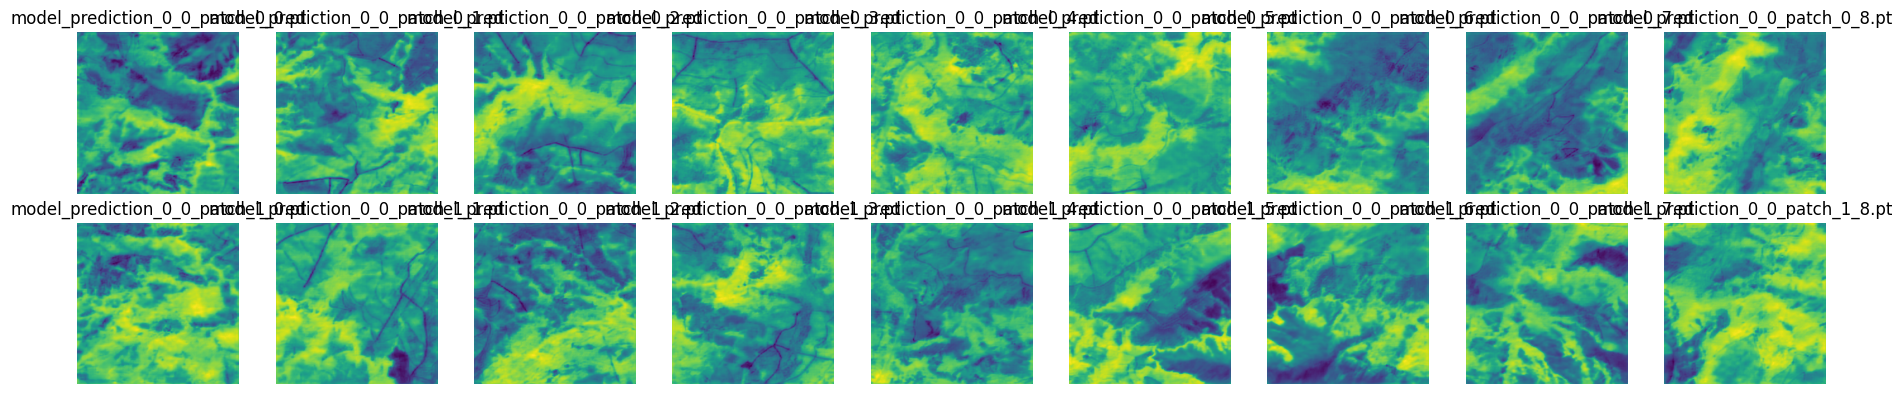

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
import re

def visualize_saved_tensors(directory):
    # List and sort tensor files numerically
    tensor_files = [f for f in os.listdir(directory) if f.endswith('.pt')]
    tensor_files.sort(key=lambda f: int(re.sub('\D', '', f)))  # Sort by numeric part of the filename

    num_files = len(tensor_files)
    rows = 2
    cols = 9
    fig, axes = plt.subplots(rows, cols, figsize=(18, 4))

    for i, tensor_file in enumerate(tensor_files):
        tensor_path = os.path.join(directory, tensor_file)
        tensor = torch.load(tensor_path)

        # Squeeze the tensor to remove the singleton dimension
        tensor = tensor.squeeze()

        ax = axes[i // cols, i % cols]
        ax.set_title(f'{tensor_file}')
        ax.imshow(tensor.numpy(), cmap='viridis')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

output_directory = '/content/drive/MyDrive/18_ont_pt_256_ndvi_pred'

# Visualize all saved tensors
visualize_saved_tensors(output_directory)


## Ground truth:

In [ ]:
# Set what image you need:
idx = '3_2'
jdx = '1_2'

Tensor shape for /content/drive/MyDrive/17_sat_pt_256/galicia_split_image_3_2_patch_1_2.pt: torch.Size([5, 256, 256])
Tensor shape for /content/drive/MyDrive/18_sat_pt_256/galicia_split_image_3_2_patch_1_2.pt: torch.Size([5, 256, 256])
Change map tensor saved to /content/drive/MyDrive/18_change_map_pred/change_map_tensor.pt
Change map plot saved to /content/drive/MyDrive/18_change_map_pred/3_2_1_2_change_map_plot_true.png


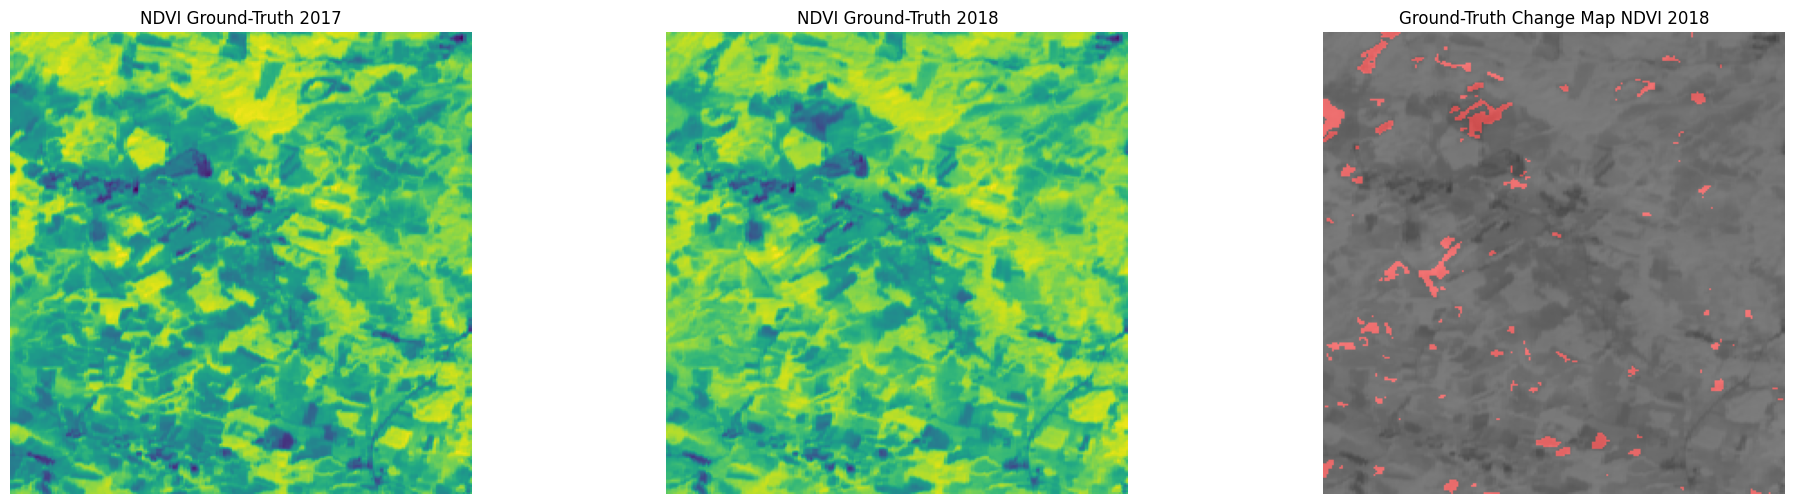

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import os

def load_and_prepare_ndvi_channel(file_path, channel=4):
    # Load the tensor
    tensor = torch.load(file_path)

    # Check the shape of the tensor
    print(f"Tensor shape for {file_path}:", tensor.shape)

    # Handle different tensor shapes
    if tensor.ndimension() == 3:
        if tensor.size(0) > channel:
            # Extract the NDVI channel (5th channel, index 4)
            ndvi_channel = tensor[channel, :, :]
        else:
            # Use the first channel if the requested channel is not available
            ndvi_channel = tensor[0, :, :]
    elif tensor.ndimension() == 2:
        # If the tensor is already 2D, use it directly
        ndvi_channel = tensor
    else:
        raise ValueError("Unexpected tensor shape")

    # Normalize the image to 0-1 range if necessary
    ndvi_channel = (ndvi_channel - ndvi_channel.min()) / (ndvi_channel.max() - ndvi_channel.min())

    return ndvi_channel

def create_change_map(ndvi1, ndvi2, threshold=0.1):
    # Ensure the NDVI images are the same size
    assert ndvi1.shape == ndvi2.shape, "Images must have the same dimensions for comparison"

    # Calculate the absolute difference
    difference = torch.abs(ndvi1 - ndvi2)

    # Create a binary mask where differences are above a threshold
    change_map = difference > threshold

    return change_map.float()

# File paths
file_path_1 = f"/content/drive/MyDrive/17_sat_pt_256/galicia_split_image_{idx}_patch_{jdx}.pt"
file_path_2 = f"/content/drive/MyDrive/18_sat_pt_256/galicia_split_image_{idx}_patch_{jdx}.pt"

# Load and prepare NDVI channels
ndvi_2017 = load_and_prepare_ndvi_channel(file_path_1)
ndvi_2018 = load_and_prepare_ndvi_channel(file_path_2)

# Create the change map
threshold = 0.2  # Adjusted threshold for better clarity
change_map = create_change_map(ndvi_2017, ndvi_2018, threshold=threshold)

# Save the change map tensor
save_folder = '/content/drive/MyDrive/18_change_map_pred'
os.makedirs(save_folder, exist_ok=True)  # Create the directory if it doesn't exist
save_path = os.path.join(save_folder, 'change_map_tensor.pt')
torch.save(change_map, save_path)
print(f"Change map tensor saved to {save_path}")

# Plot the images and the change map side by side
fig, axs = plt.subplots(1, 3, figsize=(24, 6))  # Adjusted figsize for three images

axs[0].imshow(ndvi_2017, cmap='viridis')
axs[0].set_title('NDVI Ground-Truth 2017')
axs[0].axis('off')

axs[1].imshow(ndvi_2018, cmap='viridis')
axs[1].set_title('NDVI Ground-Truth 2018')
axs[1].axis('off')

# Overlay change map on the NDVI 2018 image for better context
overlay = np.zeros((*change_map.shape, 3))
overlay[..., 0] = change_map  # Red channel for change

axs[2].imshow(ndvi_2018, cmap='gray', alpha=0.5)
axs[2].imshow(overlay, alpha=0.5)
axs[2].set_title('Ground-Truth Change Map NDVI 2018')
axs[2].axis('off')

# Save the plot as a PNG file
plot_save_path = os.path.join(save_folder, f"{idx}_{jdx}_change_map_plot_true.png")
plt.savefig(plot_save_path)
print(f"Change map plot saved to {plot_save_path}")

plt.show()


## Prediction:

Tensor shape for /content/drive/MyDrive/17_sat_pt_256/galicia_split_image_3_2_patch_1_2.pt: torch.Size([5, 256, 256])
Tensor shape for /content/drive/MyDrive/18_predictions/model_prediction_3_2_patch_1_2.pt: torch.Size([1, 256, 256])
Change map tensor saved to /content/drive/MyDrive/18_change_map_pred/change_map_tensor.pt
Change map plot saved to /content/drive/MyDrive/18_change_map_pred/3_2_1_2_change_map_plot_pred.png


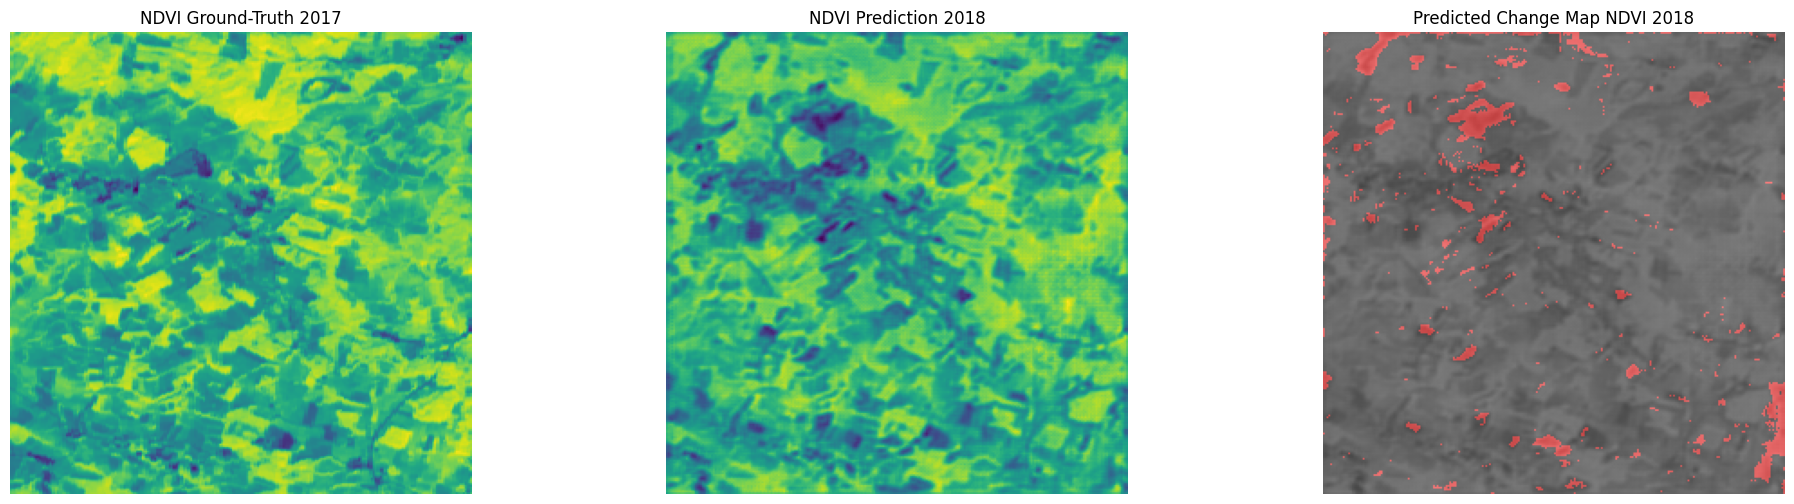

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import os

def load_and_prepare_ndvi_channel(file_path, channel=4):
    # Load the tensor
    tensor = torch.load(file_path)

    # Check the shape of the tensor
    print(f"Tensor shape for {file_path}:", tensor.shape)

    # Handle different tensor shapes
    if tensor.ndimension() == 3:
        if tensor.size(0) > channel:
            # Extract the NDVI channel (5th channel, index 4)
            ndvi_channel = tensor[channel, :, :]
        else:
            # Use the first channel if the requested channel is not available
            ndvi_channel = tensor[0, :, :]
    elif tensor.ndimension() == 2:
        # If the tensor is already 2D, use it directly
        ndvi_channel = tensor
    else:
        raise ValueError("Unexpected tensor shape")

    # Normalize the image to 0-1 range if necessary
    ndvi_channel = (ndvi_channel - ndvi_channel.min()) / (ndvi_channel.max() - ndvi_channel.min())

    return ndvi_channel

def create_change_map(ndvi1, ndvi2, threshold=0.1):
    # Ensure the NDVI images are the same size
    assert ndvi1.shape == ndvi2.shape, "Images must have the same dimensions for comparison"

    # Calculate the absolute difference
    difference = torch.abs(ndvi1 - ndvi2)

    # Create a binary mask where differences are above a threshold
    change_map = difference > threshold

    return change_map.float()

# File paths
file_path_1 = f"/content/drive/MyDrive/17_sat_pt_256/galicia_split_image_{idx}_patch_{jdx}.pt"
file_path_2 = f"/content/drive/MyDrive/18_predictions/model_prediction_{idx}_patch_{jdx}.pt"

# Load and prepare NDVI channels
ndvi_2017 = load_and_prepare_ndvi_channel(file_path_1)
ndvi_2018 = load_and_prepare_ndvi_channel(file_path_2)

# Create the change map
threshold = 0.2  # Adjusted threshold for better clarity
change_map = create_change_map(ndvi_2017, ndvi_2018, threshold=threshold)

# Save the change map tensor
save_folder = '/content/drive/MyDrive/18_change_map_pred'
os.makedirs(save_folder, exist_ok=True)  # Create the directory if it doesn't exist
save_path = os.path.join(save_folder, 'change_map_tensor.pt')
torch.save(change_map, save_path)
print(f"Change map tensor saved to {save_path}")

# Plot the images and the change map side by side
fig, axs = plt.subplots(1, 3, figsize=(24, 6))  # Adjusted figsize for three images

axs[0].imshow(ndvi_2017, cmap='viridis')
axs[0].set_title('NDVI Ground-Truth 2017')
axs[0].axis('off')

axs[1].imshow(ndvi_2018, cmap='viridis')
axs[1].set_title('NDVI Prediction 2018')
axs[1].axis('off')

# Overlay change map on the NDVI 2018 image for better context
overlay = np.zeros((*change_map.shape, 3))
overlay[..., 0] = change_map  # Red channel for change

axs[2].imshow(ndvi_2018, cmap='gray', alpha=0.5)
axs[2].imshow(overlay, alpha=0.5)
axs[2].set_title('Predicted Change Map NDVI 2018')
axs[2].axis('off')

# Save the plot as a PNG file
plot_save_path = os.path.join(save_folder, f"{idx}_{jdx}_change_map_plot_pred.png")
plt.savefig(plot_save_path)
print(f"Change map plot saved to {plot_save_path}")

plt.show()


## Continue

Tensor shape for /content/drive/MyDrive/17_sat_pt_256/galicia_split_image_3_2_patch_1_2.pt: torch.Size([5, 256, 256])
Tensor shape for /content/drive/MyDrive/18_sat_pt_256/galicia_split_image_3_1_patch_1_2.pt: torch.Size([5, 256, 256])
Change map tensor saved to /content/drive/MyDrive/18_change_map_pred/change_map_tensor.pt
Change map plot saved to /content/drive/MyDrive/18_change_map_pred/change_map_plot.png


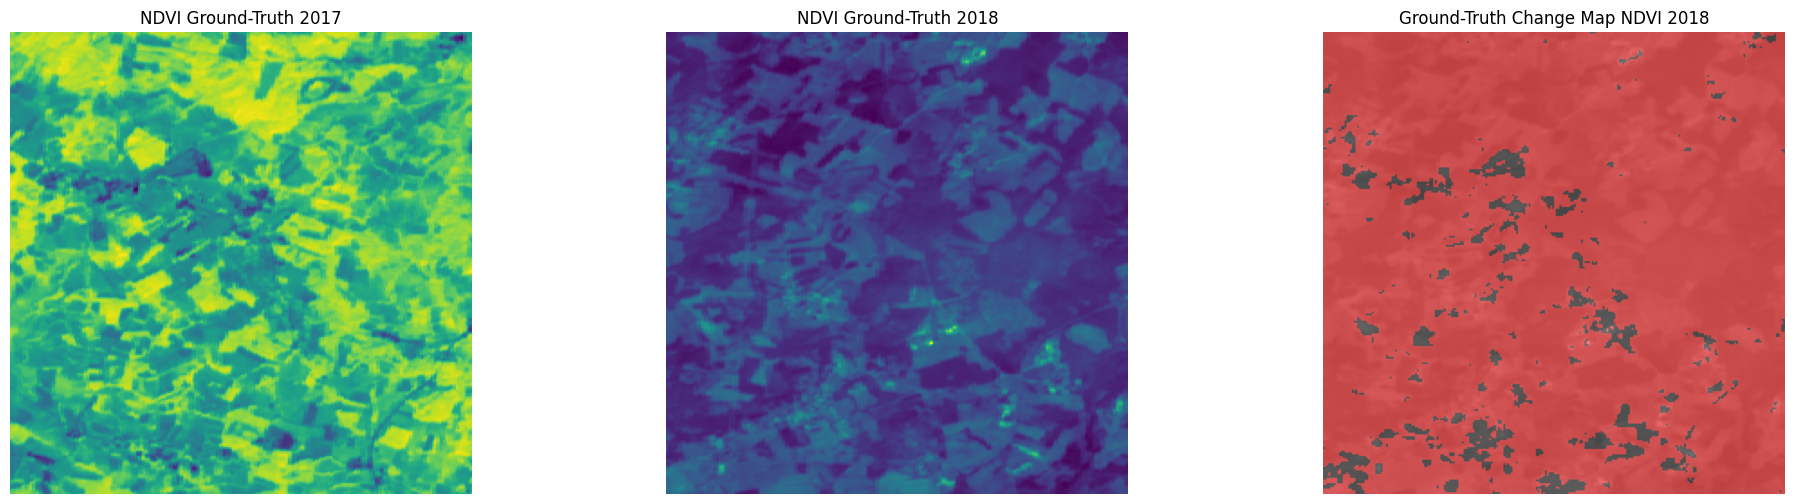

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import os

def load_and_prepare_ndvi_channel(file_path, channel=4):
    # Load the tensor
    tensor = torch.load(file_path)

    # Check the shape of the tensor
    print(f"Tensor shape for {file_path}:", tensor.shape)

    # Handle different tensor shapes
    if tensor.ndimension() == 3:
        if tensor.size(0) > channel:
            # Extract the NDVI channel (5th channel, index 4)
            ndvi_channel = tensor[channel, :, :]
        else:
            # Use the first channel if the requested channel is not available
            ndvi_channel = tensor[0, :, :]
    elif tensor.ndimension() == 2:
        # If the tensor is already 2D, use it directly
        ndvi_channel = tensor
    else:
        raise ValueError("Unexpected tensor shape")

    # Normalize the image to 0-1 range if necessary
    ndvi_channel = (ndvi_channel - ndvi_channel.min()) / (ndvi_channel.max() - ndvi_channel.min())

    return ndvi_channel

def create_change_map(ndvi1, ndvi2, threshold=0.1):
    # Ensure the NDVI images are the same size
    assert ndvi1.shape == ndvi2.shape, "Images must have the same dimensions for comparison"

    # Calculate the absolute difference
    difference = torch.abs(ndvi1 - ndvi2)

    # Create a binary mask where differences are above a threshold
    change_map = difference > threshold

    return change_map.float()

# File paths
file_path_1 = '/content/drive/MyDrive/17_sat_pt_256/galicia_split_image_3_2_patch_1_2.pt'
file_path_2 = '/content/drive/MyDrive/18_sat_pt_256/galicia_split_image_3_1_patch_1_2.pt'

# Load and prepare NDVI channels
ndvi_2017 = load_and_prepare_ndvi_channel(file_path_1)
ndvi_2018 = load_and_prepare_ndvi_channel(file_path_2, channel=0)  # Use the first channel since it's a single-channel tensor

# Create the change map
threshold = 0.2  # Adjusted threshold for better clarity
change_map = create_change_map(ndvi_2017, ndvi_2018, threshold=threshold)

# Save the change map tensor
save_folder = '/content/drive/MyDrive/18_change_map_pred'
os.makedirs(save_folder, exist_ok=True)  # Create the directory if it doesn't exist
save_path = os.path.join(save_folder, 'change_map_tensor.pt')
torch.save(change_map, save_path)
print(f"Change map tensor saved to {save_path}")

# Plot the images and the change map side by side
fig, axs = plt.subplots(1, 3, figsize=(24, 6))  # Adjusted figsize for three images

axs[0].imshow(ndvi_2017, cmap='viridis')
axs[0].set_title('NDVI Ground-Truth 2017')
axs[0].axis('off')

axs[1].imshow(ndvi_2018, cmap='viridis')
axs[1].set_title('NDVI Ground-Truth 2018')
axs[1].axis('off')

# Overlay change map on the NDVI 2018 image for better context
overlay = np.zeros((*change_map.shape, 3))
overlay[..., 0] = change_map  # Red channel for change

axs[2].imshow(ndvi_2018, cmap='gray', alpha=0.5)
axs[2].imshow(overlay, alpha=0.5)
axs[2].set_title('Ground-Truth Change Map NDVI 2018')
axs[2].axis('off')

# Save the plot as a PNG file
plot_save_path = os.path.join(save_folder, 'change_map_plot.png')
plt.savefig(plot_save_path)
print(f"Change map plot saved to {plot_save_path}")

plt.show()


Tensor shape for /content/drive/MyDrive/17_sat_pt_256/galicia_split_image_3_3_patch_1_2.pt: torch.Size([5, 256, 256])
Tensor shape for /content/drive/MyDrive/18_sat_pt_256/galicia_split_image_3_3_patch_1_2.pt: torch.Size([5, 256, 256])
Change map tensor saved to /content/drive/MyDrive/18_change_map_GT/change_map_tensor.pt
Change map plot saved to /content/drive/MyDrive/18_change_map_GT/change_map_plot.png


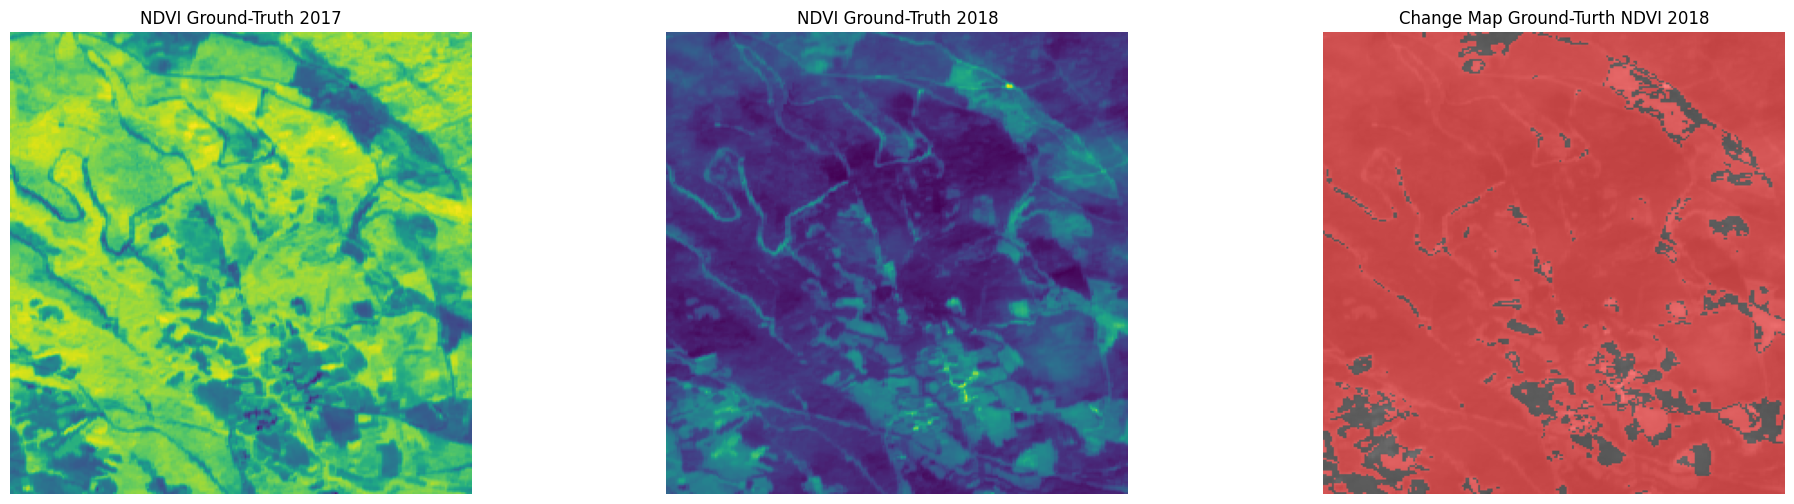

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import os

def load_and_prepare_ndvi_channel(file_path, channel=4):
    # Load the tensor
    tensor = torch.load(file_path)

    # Check the shape of the tensor
    print(f"Tensor shape for {file_path}:", tensor.shape)

    # Handle different tensor shapes
    if tensor.ndimension() == 3:
        if tensor.size(0) > channel:
            # Extract the NDVI channel (5th channel, index 4)
            ndvi_channel = tensor[channel, :, :]
        else:
            # Use the first channel if the requested channel is not available
            ndvi_channel = tensor[0, :, :]
    elif tensor.ndimension() == 2:
        # If the tensor is already 2D, use it directly
        ndvi_channel = tensor
    else:
        raise ValueError("Unexpected tensor shape")

    # Normalize the image to 0-1 range if necessary
    ndvi_channel = (ndvi_channel - ndvi_channel.min()) / (ndvi_channel.max() - ndvi_channel.min())

    return ndvi_channel

def create_change_map(ndvi1, ndvi2, threshold=0.1):
    # Ensure the NDVI images are the same size
    assert ndvi1.shape == ndvi2.shape, "Images must have the same dimensions for comparison"

    # Calculate the absolute difference
    difference = torch.abs(ndvi1 - ndvi2)

    # Create a binary mask where differences are above a threshold
    change_map = difference > threshold

    return change_map.float()

# File paths
file_path_1 = '/content/drive/MyDrive/17_sat_pt_256/galicia_split_image_3_3_patch_1_2.pt'
file_path_2 = '/content/drive/MyDrive/18_sat_pt_256/galicia_split_image_3_3_patch_1_2.pt'

# Load and prepare NDVI channels
ndvi_2017 = load_and_prepare_ndvi_channel(file_path_1)
ndvi_2018 = load_and_prepare_ndvi_channel(file_path_2, channel=0)  # Use the first channel since it's a single-channel tensor

# Create the change map
threshold = 0.1  # Adjusted threshold for better clarity
change_map = create_change_map(ndvi_2017, ndvi_2018, threshold=threshold)

# Save the change map tensor
save_folder = '/content/drive/MyDrive/18_change_map_GT'
os.makedirs(save_folder, exist_ok=True)  # Create the directory if it doesn't exist
save_path = os.path.join(save_folder, 'change_map_tensor.pt')
torch.save(change_map, save_path)
print(f"Change map tensor saved to {save_path}")

# Plot the images and the change map side by side
fig, axs = plt.subplots(1, 3, figsize=(24, 6))  # Adjusted figsize for three images

axs[0].imshow(ndvi_2017, cmap='viridis')
axs[0].set_title('NDVI Ground-Truth 2017')
axs[0].axis('off')

axs[1].imshow(ndvi_2018, cmap='viridis')
axs[1].set_title('NDVI Ground-Truth 2018')
axs[1].axis('off')

# Overlay change map on the NDVI 2018 image for better context
overlay = np.zeros((*change_map.shape, 3))
overlay[..., 0] = change_map  # Red channel for change

axs[2].imshow(ndvi_2018, cmap='gray', alpha=0.5)
axs[2].imshow(overlay, alpha=0.5)
axs[2].set_title('Change Map Ground-Turth NDVI 2018')
axs[2].axis('off')

# Save the plot as a PNG file
plot_save_path = os.path.join(save_folder, 'change_map_plot.png')
plt.savefig(plot_save_path)
print(f"Change map plot saved to {plot_save_path}")

plt.show()


Tensor shape for /content/drive/MyDrive/18_ont_pt_256_ndvi_pred/model_prediction_0.pt: torch.Size([1, 256, 256])
Change map comparison plot saved to /content/drive/MyDrive/18_change_map_diff/change_map_comparison.png


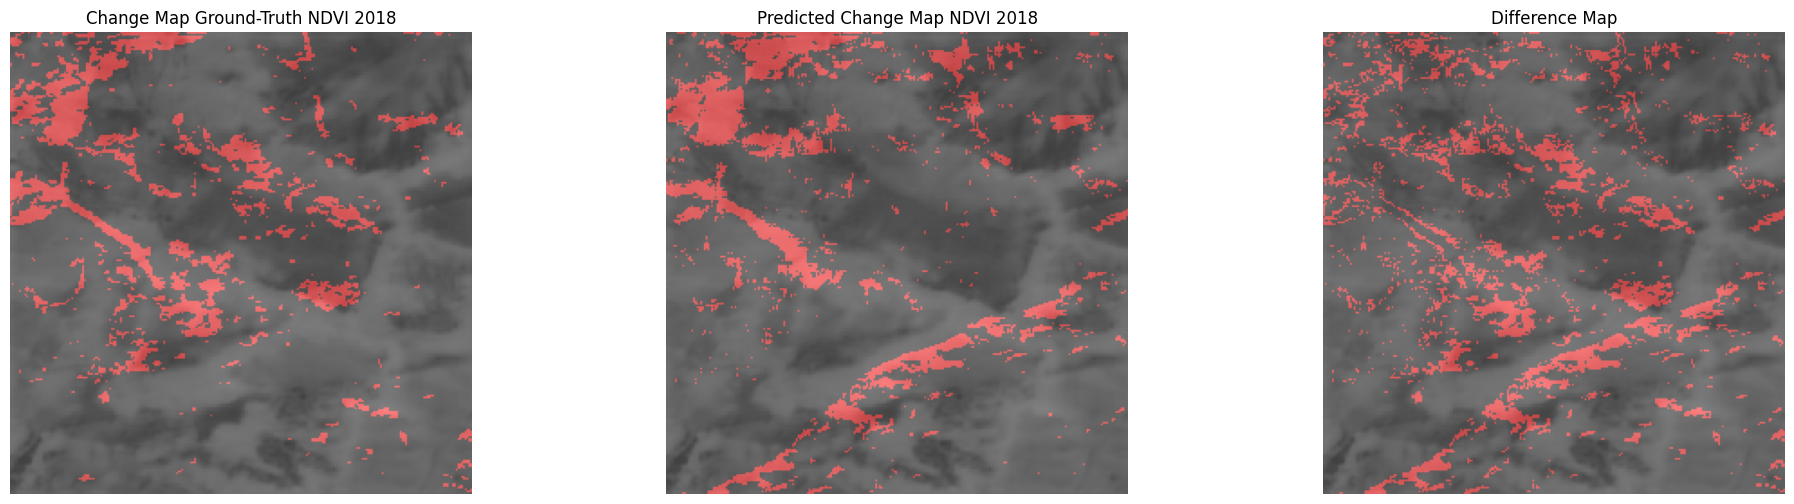

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import os

def load_and_prepare_ndvi_channel(file_path, channel=4):
    # Load the tensor
    tensor = torch.load(file_path)

    # Check the shape of the tensor
    print(f"Tensor shape for {file_path}:", tensor.shape)

    # Handle different tensor shapes
    if tensor.ndimension() == 3:
        if tensor.size(0) > channel:
            # Extract the NDVI channel (5th channel, index 4)
            ndvi_channel = tensor[channel, :, :]
        else:
            # Use the first channel if the requested channel is not available
            ndvi_channel = tensor[0, :, :]
    elif tensor.ndimension() == 2:
        # If the tensor is already 2D, use it directly
        ndvi_channel = tensor
    else:
        raise ValueError("Unexpected tensor shape")

    # Normalize the image to 0-1 range if necessary
    ndvi_channel = (ndvi_channel - ndvi_channel.min()) / (ndvi_channel.max() - ndvi_channel.min())

    return ndvi_channel

# Load the saved change map tensors
change_map_gt_path = '/content/drive/MyDrive/18_change_map_GT/change_map_tensor.pt'
change_map_pred_path = '/content/drive/MyDrive/18_change_map_pred/change_map_tensor.pt'

change_map_gt = torch.load(change_map_gt_path)
change_map_pred = torch.load(change_map_pred_path)

# Ensure the tensors have the same shape
assert change_map_gt.shape == change_map_pred.shape, "Tensors must have the same shape for comparison"

# Calculate the difference map
difference_map = torch.abs(change_map_gt - change_map_pred)

# Load the NDVI 2018 image for context (assuming it's the same as used in the creation of change maps)
ndvi_2018_path = '/content/drive/MyDrive/18_ont_pt_256_ndvi_pred/model_prediction_0.pt'
ndvi_2018 = load_and_prepare_ndvi_channel(ndvi_2018_path, channel=0)

# Plot the ground-truth, predicted change maps, and the difference map
fig, axs = plt.subplots(1, 3, figsize=(24, 6))  # Adjusted figsize for three images

# Overlay ground-truth change map on the NDVI 2018 image for better context
overlay_gt = np.zeros((*change_map_gt.shape, 3))
overlay_gt[..., 0] = change_map_gt  # Red channel for change

axs[0].imshow(ndvi_2018, cmap='gray', alpha=0.5)
axs[0].imshow(overlay_gt, alpha=0.5)
axs[0].set_title('Change Map Ground-Truth NDVI 2018')
axs[0].axis('off')

# Overlay predicted change map on the NDVI 2018 image for better context
overlay_pred = np.zeros((*change_map_pred.shape, 3))
overlay_pred[..., 0] = change_map_pred  # Red channel for change

axs[1].imshow(ndvi_2018, cmap='gray', alpha=0.5)
axs[1].imshow(overlay_pred, alpha=0.5)
axs[1].set_title('Predicted Change Map NDVI 2018')
axs[1].axis('off')

# Overlay difference map on the NDVI 2018 image for better context
overlay_diff = np.zeros((*difference_map.shape, 3))
overlay_diff[..., 0] = difference_map  # Red channel for change

axs[2].imshow(ndvi_2018, cmap='gray', alpha=0.5)
axs[2].imshow(overlay_diff, alpha=0.5)
axs[2].set_title('Difference Map')
axs[2].axis('off')

# Save the plot as a PNG file
save_folder = '/content/drive/MyDrive/18_change_map_diff'
os.makedirs(save_folder, exist_ok=True)  # Create the directory if it doesn't exist
plot_save_path = os.path.join(save_folder, 'change_map_comparison.png')
plt.savefig(plot_save_path)
print(f"Change map comparison plot saved to {plot_save_path}")

plt.show()


In [ ]:
save_path = '/content/drive/MyDrive/Thesis Esmee/resunet_ont_results.pkl'

# Load the results from the pickle file
with open(save_path, 'rb') as f:
    results = pickle.load(f)

# Example: visualize predictions for the first fold
first_fold_results = results[5]
visualize_predictions(
    first_fold_results['inputs'],
    first_fold_results['targets'],
    first_fold_results['outputs'],
    num_samples=5
)

This cell output is too large and can only be displayed while logged in.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

def visualize_predictions_with_diff(inputs, targets, outputs, num_samples=5):
    inputs = np.array(inputs)
    targets = np.array(targets)
    outputs = np.array(outputs)
    differences = np.abs(targets - outputs)  # Calculate absolute differences

    for i in range(num_samples):
        plt.figure(figsize=(16, 4))

        plt.subplot(1, 4, 1)
        plt.title('Input Image')
        plt.imshow(inputs[i, 0], cmap='gray')

        plt.subplot(1, 4, 2)
        plt.title('Ground Truth')
        plt.imshow(targets[i, 0], cmap='viridis')

        plt.subplot(1, 4, 3)
        plt.title('Model Prediction')
        plt.imshow(outputs[i, 0], cmap='viridis')

        plt.subplot(1, 4, 4)
        plt.title('Difference Map')
        plt.imshow(differences[i, 0], cmap='hot')

        plt.show()

# Load the results from the pickle file
save_path = '/content/drive/MyDrive/Thesis Esmee/resunet_ont_results.pkl'
with open(save_path, 'rb') as f:
    results = pickle.load(f)

# Example: visualize predictions and difference maps for the first fold
first_fold_results = results[5]
visualize_predictions_with_diff(
    first_fold_results['inputs'],
    first_fold_results['targets'],
    first_fold_results['outputs'],
    num_samples=5
)


This cell output is too large and can only be displayed while logged in.


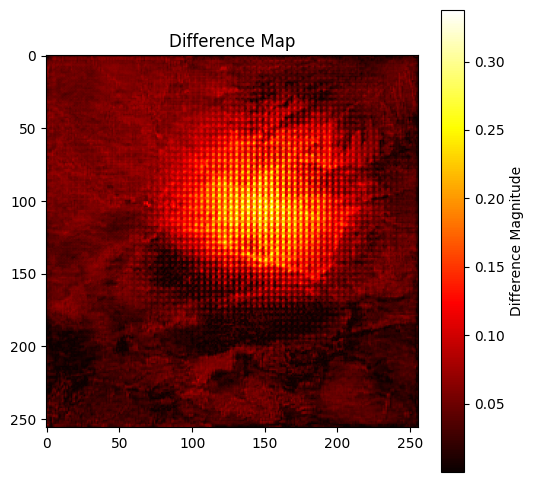

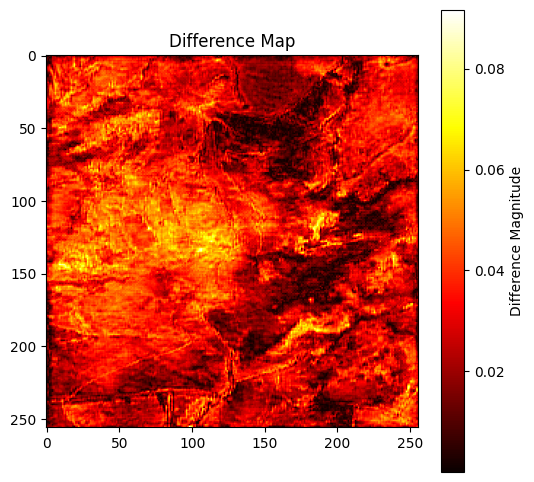

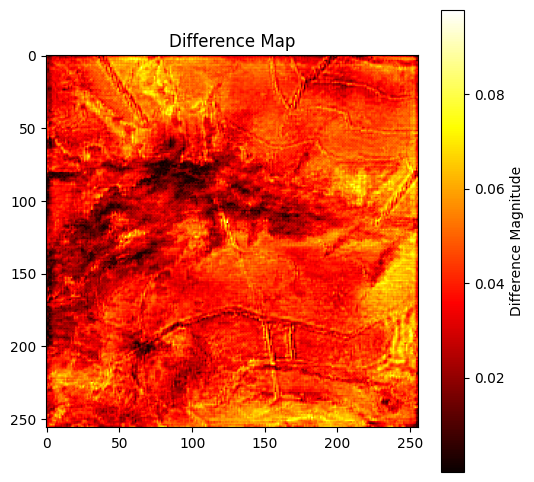

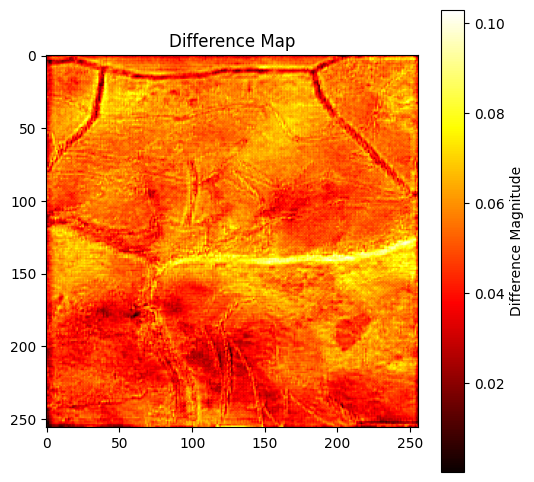

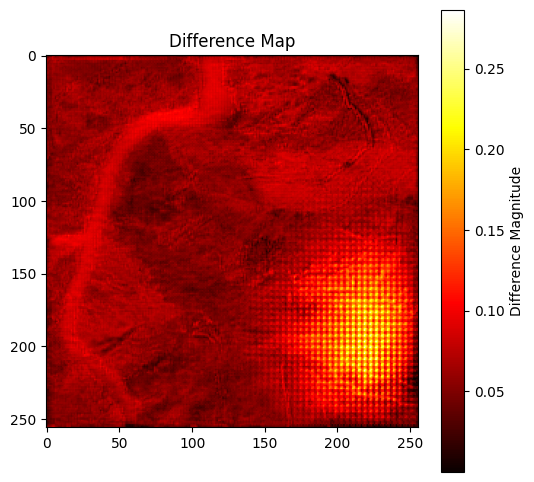

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

def visualize_difference_maps(targets, outputs, num_samples=5):
    targets = np.array(targets)
    outputs = np.array(outputs)
    differences = np.abs(targets - outputs)  # Calculate absolute differences

    for i in range(num_samples):
        plt.figure(figsize=(6, 6))

        plt.title('Difference Map')
        img = plt.imshow(differences[i, 0], cmap='hot')
        plt.colorbar(img, orientation='vertical', label='Difference Magnitude')

        plt.show()

# Load the results from the pickle file
save_path = '/content/drive/MyDrive/Thesis Esmee/resunet_ont_results_NS.pkl'
with open(save_path, 'rb') as f:
    results = pickle.load(f)

# Example: visualize difference maps for the first fold
first_fold_results = results[1]
visualize_difference_maps(
    first_fold_results['targets'],
    first_fold_results['outputs'],
    num_samples=5
)


In [ ]:
import matplotlib.pyplot as plt

def visualize_predictions(model, test_loader, num_samples=5):
    model.eval()
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(test_loader):
            if i >= num_samples:
                break
            inputs, targets = inputs.cuda(), targets.cuda()
            outputs = model(inputs)

            # Convert to numpy for visualization
            inputs = inputs.cpu().numpy()
            targets = targets.cpu().numpy()
            outputs = outputs.cpu().numpy()

            # Plot the results
            for j in range(inputs.shape[0]):
                plt.figure(figsize=(12, 4))

                plt.subplot(1, 3, 1)
                plt.title('Input Image')
                plt.imshow(inputs[j, 0], cmap='gray')  # Adjust based on your image format

                plt.subplot(1, 3, 2)
                plt.title('Ground Truth')
                plt.imshow(targets[j, 0], cmap='gray')

                plt.subplot(1, 3, 3)
                plt.title('Model Prediction')
                plt.imshow(outputs[j, 0], cmap='gray')

                plt.show()

# Assuming new_test_loader is defined and the model is loaded
visualize_predictions(model, new_test_loader, num_samples=5)


This cell output is too large and can only be displayed while logged in.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import matplotlib.colors as mcolors

def visualize_predictions_with_errors(model, test_loader, num_samples=5):
    model.eval()
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(test_loader):
            if i >= num_samples:
                break
            inputs, targets = inputs.cuda(), targets.cuda()
            outputs = model(inputs)

            # Convert to numpy for visualization
            inputs = inputs.cpu().numpy()
            targets = targets.cpu().numpy()
            outputs = outputs.cpu().numpy()

            # Compute error maps
            errors = np.abs(outputs - targets)

            # Plot the results
            for j in range(inputs.shape[0]):
                plt.figure(figsize=(15, 5))

                plt.subplot(1, 4, 1)
                plt.title('Input Image')
                plt.imshow(inputs[j, 0], cmap='gray')  # Adjust based on your image format

                plt.subplot(1, 4, 2)
                plt.title('Ground Truth')
                plt.imshow(targets[j, 0], cmap='gray')

                plt.subplot(1, 4, 3)
                plt.title('Model Prediction')
                plt.imshow(outputs[j, 0], cmap='gray')

                plt.subplot(1, 4, 4)
                plt.title('Prediction Error')
                norm = mcolors.Normalize(vmin=errors[j].min(), vmax=errors[j].max())
                plt.imshow(errors[j, 0], cmap='autumn', norm=norm)
                plt.colorbar(label='Error')

                plt.show()

# Assuming new_test_loader is defined and the model is loaded
visualize_predictions_with_errors(model, new_test_loader, num_samples=5)


This cell output is too large and can only be displayed while logged in.


In [ ]:
import numpy as np
import torch

def extract_features_and_errors(model, test_loader):
    model.eval()
    channel_5_features = []
    prediction_errors = []

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.cuda(), targets.cuda()
            outputs = model(inputs)

            # Convert to numpy for processing
            inputs = inputs.cpu().numpy()
            targets = targets.cpu().numpy()
            outputs = outputs.cpu().numpy()

            # Extract features from channel 5
            features = inputs[:, 4, :, :]  # Channel 5 is index 4 in 0-based indexing

            # Compute the prediction errors
            errors = np.abs(outputs - targets)

            # Flatten the arrays for correlation calculation
            channel_5_features.extend(features.flatten())
            prediction_errors.extend(errors.flatten())

    return np.array(channel_5_features), np.array(prediction_errors)

# Assuming new_test_loader is defined and the model is loaded
features, errors = extract_features_and_errors(model, new_test_loader)


In [ ]:
save_path = '/content/drive/MyDrive/Thesis Esmee/resunet_ont_results.pkl'

# Load the results from the pickle file
with open(save_path, 'rb') as f:
    results = pickle.load(f)

Keys in results: [1, 2, 3, 4, 5]
First key to inspect: 1
Shape of selected channel features: (18, 256, 256)
Shape of errors: (18, 256, 256)
Length of flattened features: 1179648
Length of flattened errors: 1179648
Correlation between features in channel 5 and prediction error: 0.0444 (p-value: 0.0000e+00)


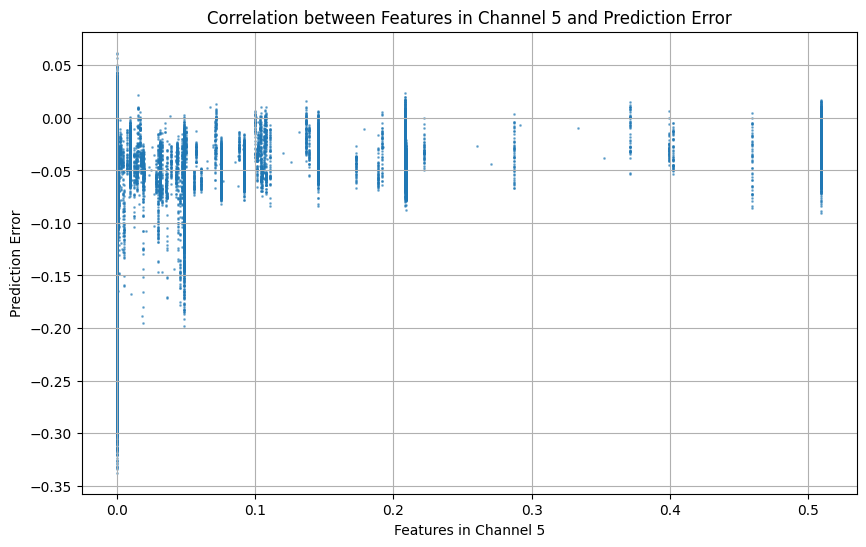

In [ ]:
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

save_path = '/content/drive/MyDrive/Thesis Esmee/resunet_ont_results.pkl'

# Load the results from the pickle file
if os.path.exists(save_path):
    with open(save_path, 'rb') as f:
        try:
            results = pickle.load(f)

            # Verify and list all keys
            keys = list(results.keys())
            print(f"Keys in results: {keys}")

            # Let's pick the first key dynamically
            first_key = keys[0]
            print(f"First key to inspect: {first_key}")

            # Inspect the first inner dictionary
            first_inner_dict = results[first_key]
            inputs = first_inner_dict.get('inputs', None)
            targets = first_inner_dict.get('targets', None)
            outputs = first_inner_dict.get('outputs', None)

            if inputs is not None and targets is not None and outputs is not None:
                # Convert inputs to numpy array and select the specific channel (e.g., channel 5)
                features = np.array(inputs)[:, 6, :, :]  # Selecting the 5th channel (index 4)

                # Calculate errors as the difference between targets and outputs
                errors = np.array([t - o for t, o in zip(targets, outputs)])

                # Remove the extra dimension from errors (squeeze to remove singleton dimensions)
                errors = errors.squeeze(axis=1)

                # Print shapes for debugging
                print(f"Shape of selected channel features: {features.shape}")
                print(f"Shape of errors: {errors.shape}")

                # Flatten the arrays for correlation calculation
                features_flat = features.flatten()
                errors_flat = errors.flatten()

                # Print lengths for debugging
                print(f"Length of flattened features: {len(features_flat)}")
                print(f"Length of flattened errors: {len(errors_flat)}")

                if len(features_flat) == len(errors_flat):
                    # Calculate correlation
                    correlation, p_value = scipy.stats.pearsonr(features_flat, errors_flat)
                    print(f"Correlation between features in channel 5 and prediction error: {correlation:.4f} (p-value: {p_value:.4e})")

                    # Plot the correlation
                    plt.figure(figsize=(10, 6))
                    plt.scatter(features_flat, errors_flat, alpha=0.5, s=1)
                    plt.title('Correlation between Features in Channel 5 and Prediction Error')
                    plt.xlabel('Features in Channel 5')
                    plt.ylabel('Prediction Error')
                    plt.grid(True)
                    plt.show()
                else:
                    print("Flattened features and errors do not have the same length.")
            else:
                print("The required data 'inputs', 'targets', or 'outputs' is missing in the results.")
        except Exception as e:
            print(f"An error occurred while loading the pickle file: {e}")
else:
    print(f"The file {save_path} does not exist.")


In [ ]:
import matplotlib.pyplot as plt
import scipy.stats

# Calculate correlation
correlation, p_value = scipy.stats.pearsonr(features, errors)
print(f"Correlation between features in channel 5 and prediction error: {correlation:.4f} (p-value: {p_value:.4e})")

# Plot the correlation
plt.figure(figsize=(10, 6))
plt.scatter(features, errors, alpha=0.5, s=1)
plt.title('Correlation between Features in Channel 5 and Prediction Error')
plt.xlabel('Features in Channel 5')
plt.ylabel('Prediction Error')
plt.grid(True)
plt.show()


NameError: name 'features' is not defined

In [ ]:
import numpy as np
import torch

def extract_features_and_errors(model, test_loader):
    model.eval()
    all_channel_features = [[] for _ in range(8)]  # Assuming 8 channels
    prediction_errors = []

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.cuda(), targets.cuda()
            outputs = model(inputs)

            # Convert to numpy for processing
            inputs = inputs.cpu().numpy()
            targets = targets.cpu().numpy()
            outputs = outputs.cpu().numpy()

            # Extract features from all channels
            for channel in range(8):
                features = inputs[:, channel, :, :]  # Extracting each channel
                all_channel_features[channel].extend(features.flatten())

            # Compute the prediction errors
            errors = np.abs(outputs - targets)
            prediction_errors.extend(errors.flatten())

    all_channel_features = [np.array(features) for features in all_channel_features]
    return all_channel_features, np.array(prediction_errors)

# Assuming new_test_loader is defined and the model is loaded
all_features, errors = extract_features_and_errors(model, new_test_loader)


Correlation between features in channel 1 and prediction error: -0.5279 (p-value: 0.0000e+00)
Correlation between features in channel 2 and prediction error: -0.4800 (p-value: 0.0000e+00)
Correlation between features in channel 3 and prediction error: -0.5831 (p-value: 0.0000e+00)
Correlation between features in channel 4 and prediction error: 0.0261 (p-value: 1.7265e-176)
Correlation between features in channel 5 and prediction error: 0.2617 (p-value: 0.0000e+00)
Correlation between features in channel 6 and prediction error: 0.0370 (p-value: 0.0000e+00)
Correlation between features in channel 7 and prediction error: 0.0232 (p-value: 1.1191e-139)
Correlation between features in channel 8 and prediction error: 0.0302 (p-value: 4.7413e-236)


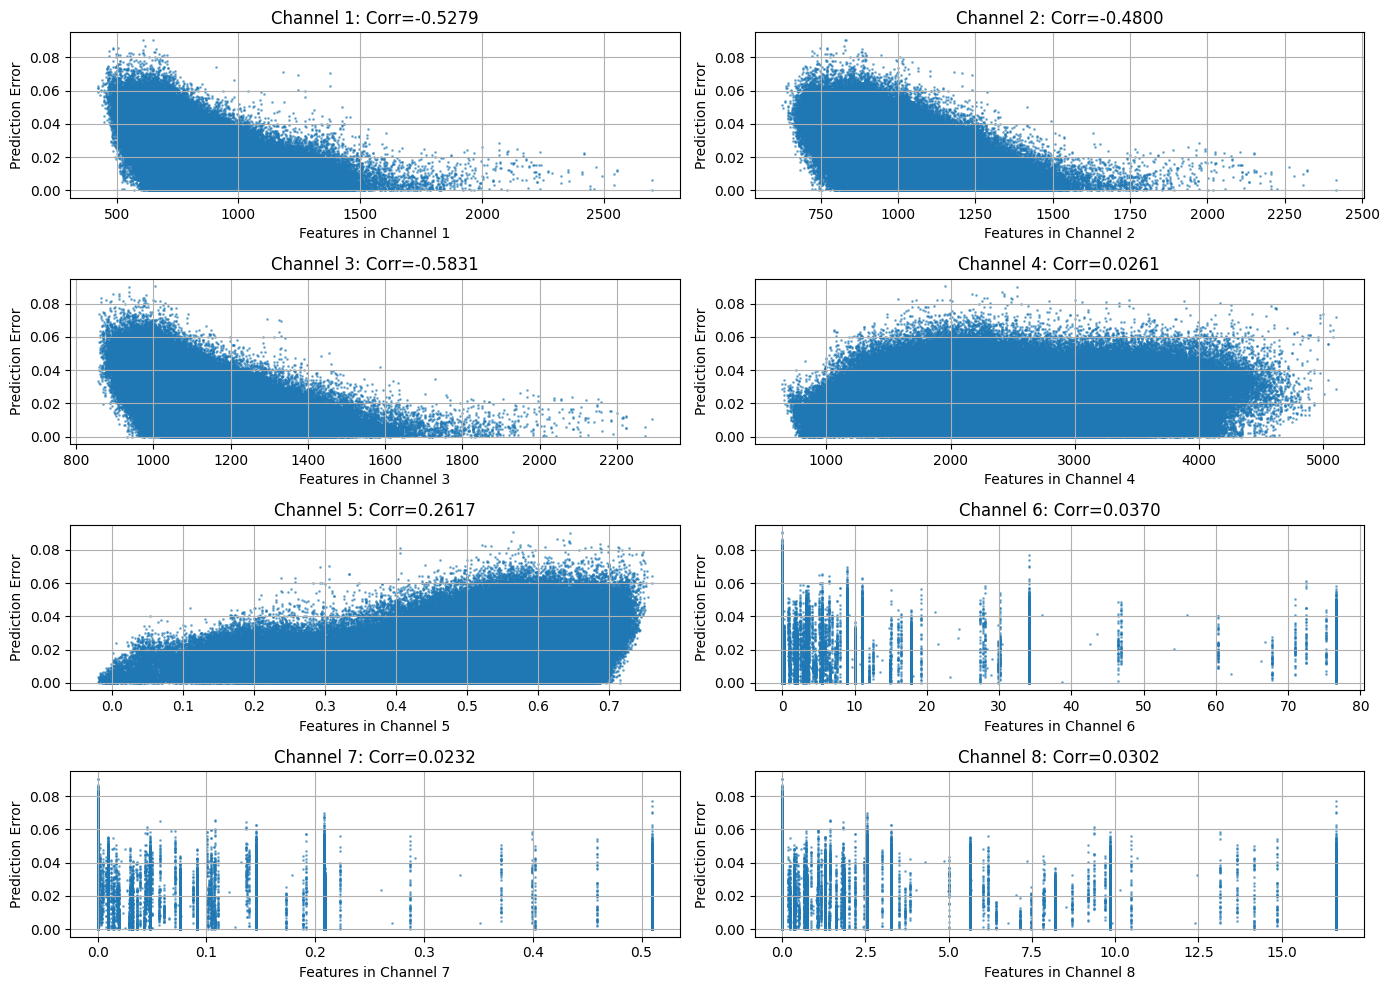

In [ ]:
import matplotlib.pyplot as plt
import scipy.stats

# Calculate correlation for each channel
correlations = []
p_values = []
for channel in range(8):
    correlation, p_value = scipy.stats.pearsonr(all_features[channel], errors)
    correlations.append(correlation)
    p_values.append(p_value)
    print(f"Correlation between features in channel {channel + 1} and prediction error: {correlation:.4f} (p-value: {p_value:.4e})")

# Plot the correlations for all channels
plt.figure(figsize=(14, 10))
for channel in range(8):
    plt.subplot(4, 2, channel + 1)
    plt.scatter(all_features[channel], errors, alpha=0.5, s=1)
    plt.title(f'Channel {channel + 1}: Corr={correlations[channel]:.4f}')
    plt.xlabel(f'Features in Channel {channel + 1}')
    plt.ylabel('Prediction Error')
    plt.grid(True)

plt.tight_layout()
plt.show()


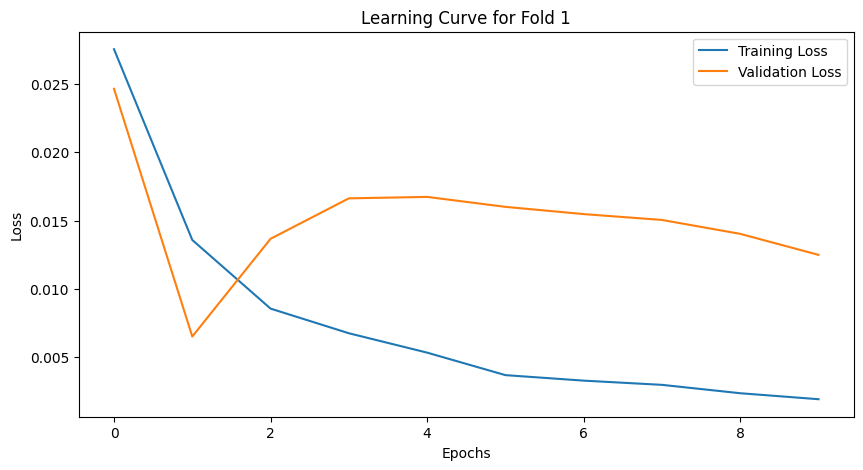

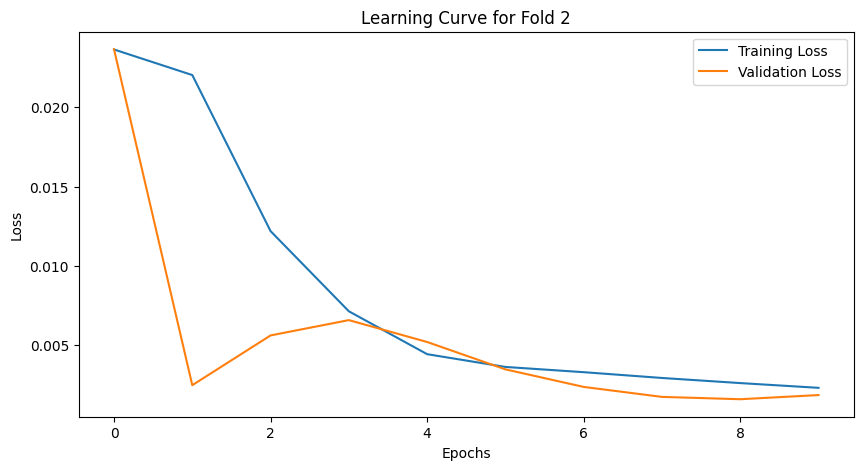

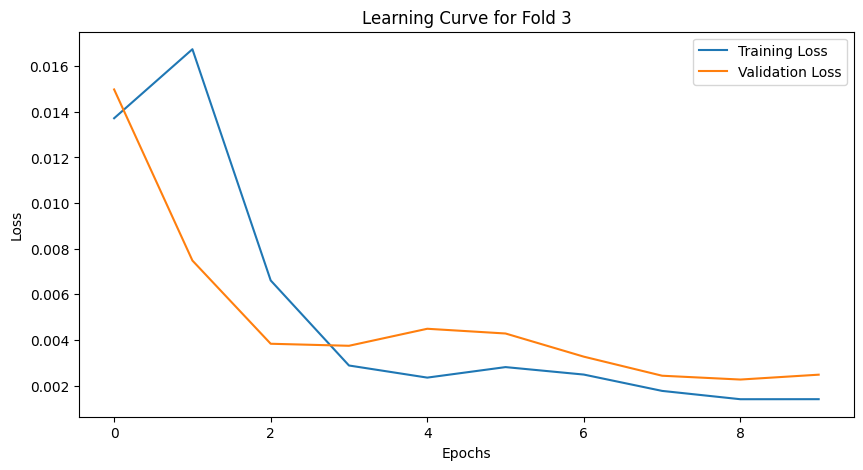

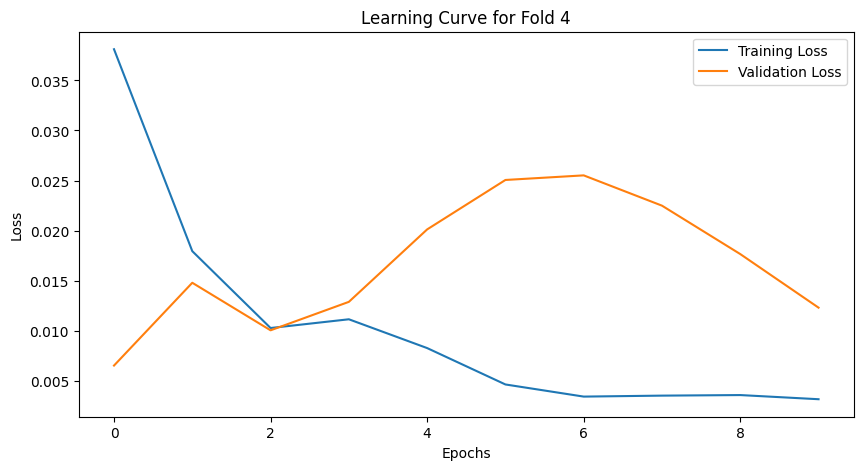

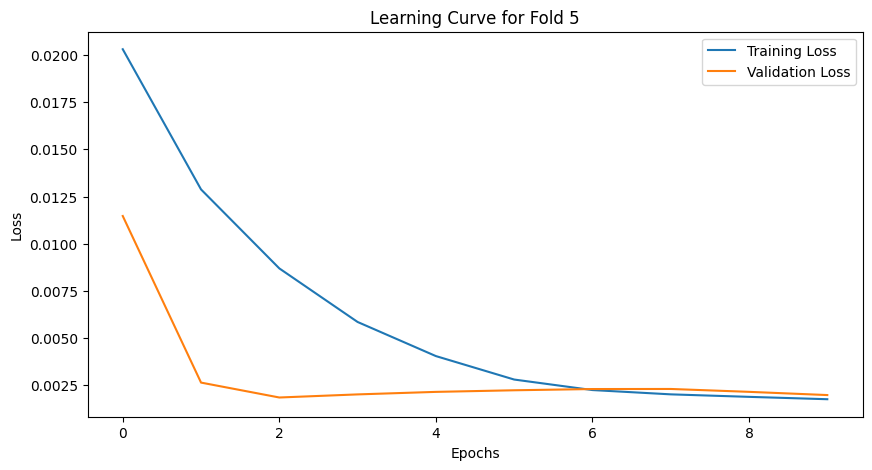

In [ ]:
import matplotlib.pyplot as plt

# Assuming fold_train_losses and fold_val_losses are lists of lists where each sublist corresponds to a fold
for i, (train_losses, val_losses) in enumerate(zip(fold_train_losses, fold_val_losses)):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title(f'Learning Curve for Fold {i+1}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


In [ ]:
pip install matplotlib basemap geopandas folium

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 936.0/936.0 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 50.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 9.0 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.1
    Uninstalling packaging-24.1:
      Successfully uninstalled packaging-24.1


In [ ]:
import pandas as pd
import numpy as np

# Generating random sample data within the specified coordinate range and NDVI values
np.random.seed(42)  # For reproducibility

# Example realistic NDVI values and coordinates
data = {
    'latitude': np.random.uniform(low=41.797418, high=42.333241, size=4),
    'longitude': np.random.uniform(low=-8.599948, high=-8.022484, size=4),
    'actual_ndvi': np.random.uniform(low=0.50, high=0.75, size=4),  # Example range for NDVI
    'predicted_ndvi': np.random.uniform(low=0.48, high=0.77, size=4)  # Example predictions, can overlap actual
}

df = pd.DataFrame(data)

print(df)


    latitude  longitude  actual_ndvi  predicted_ndvi
0  41.998105  -8.509853     0.650279        0.721408
1  42.306833  -8.509867     0.677018        0.541578
2  42.189637  -8.566407     0.505146        0.532729
3  42.118193  -8.099762     0.742477        0.533187


In [ ]:
import folium

# Create a base map
map = folium.Map(location=[35.5, -117.5], zoom_start=6, tiles='OpenStreetMap')

# Adding actual NDVI points
for _, row in df.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=5,
        color='green',
        fill=True,
        fill_color='green',
        fill_opacity=0.7,
        popup=f"Actual NDVI: {row['actual_ndvi']}"
    ).add_to(map)

# Adding predicted NDVI points
for _, row in df.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=5,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7,
        popup=f"Predicted NDVI: {row['predicted_ndvi']}"
    ).add_to(map)

# Save or show the map
map.save("NDVI_Map.html")  # Saves the map as an HTML file
# map  # If running in a Jupyter notebook, just typing `map` will display it


In [ ]:
map